## Variable that changed a lot

In [1]:
Model_name = "Resnet_18"
run_num  = "4"         
# It should match the the name of notebook
tensor_baord_variable = Model_name + '_' + run_num

# The path of the best check point
path = f"CheckPoints/{tensor_baord_variable}"

In [2]:
tensor_baord_variable, path

('Resnet_18_4', 'CheckPoints/Resnet_18_4')

## Check the working environment

In [3]:
import sys
def is_venv(): return hasattr(sys, 'real_prefix') or sys.base_prefix != sys.prefix

print("sys.base_prefix >> ", sys.base_prefix)
print("sys.prefix >> ", sys.prefix)

print("is_venv():", is_venv())

sys.base_prefix >>  /usr
sys.prefix >>  /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang
is_venv(): True


In [4]:
import os

if os.getenv('VIRTUAL_ENV'):
    print('Using Virtualenv')
else:
    print('Not using Virtualenv')

Using Virtualenv


In [5]:
import sys
import os

print(f'Python Executable: {sys.executable}')
print(f'Python Version: {sys.version}')
print(f'Virtualenv: {os.getenv("VIRTUAL_ENV")}')

Python Executable: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang/bin/python
Python Version: 3.8.10 (default, May 26 2023, 14:05:08) 
[GCC 9.4.0]
Virtualenv: /home/lenovo/Desktop/Barham/Conferance_Sign_Language_paper/conf_sign_lang


## Import libraries

In [6]:
## Import important libraries 

import torch 
from torch import nn 
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import torchvision
print(torch.__version__)

1.10.0+cu102


In [7]:
# Tune the seed to get the same result for every run for the same parameters
# Remove the randomness in the results 

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Check the availabitlity of GPU

In [8]:
# Chech the nvidia compiler driver
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [9]:
# check if CUDA is available

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda" if train_on_gpu else "cpu")


CUDA is available!  Training on GPU ...


In [10]:
# check the device proparities
torch.cuda.get_device_properties(torch.cuda.current_device())

_CudaDeviceProperties(name='Quadro GV100', major=7, minor=0, total_memory=32505MB, multi_processor_count=80)

## Dataset Pre-processing

In [11]:
import os

In [12]:
# This class is used to apply specific transform on  the data 

class InheritedDataset():
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y, images_path = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y, images_path
    
    def __len__(self):
        return len(self.dataset)

In [13]:
# Transformation or Processing for the dataset 

img_size = 224

trans = transforms.Compose([  transforms.Resize(img_size),
                              transforms.CenterCrop(img_size),
                              transforms.ToTensor(),
                            
 ] )

transNoAugment = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                                transforms.ToTensor(),
 ] )

In [14]:
# https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

import torch
from torchvision import datasets
from PIL import Image, ImageOps
from typing import Any # , Callable, cast, Dict, List, Optional, Tuple

class ImageFolderWithPaths(datasets.ImageFolder):
    """
    Custom dataset that includes image file paths. 
    Extends for torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        # print('Here')
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
#        print("Hello")
        # print(traindataset)
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [15]:
# "https://stackoverflow.com/questions/12984426/pil-ioerror-image-file-truncated-with-big-images"

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
def custom_pil_loader(path: str) -> Image.Image:
    """
    This function is used to fix the orientation of the image based on its EXIF data (Exchangeable Image File Format). 
    It handles cases where the image may have been rotated or flipped based on the device or software used to capture it.
    """
    
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    # with open(path, "rb") as f:
    # print("Second")

    with open(path, "rb") as f:
        img = Image.open(f)
    
        fixed_image = ImageOps.exif_transpose(img)
        return fixed_image.convert("RGB")

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
# Assign the batch size and number of workers

batch_size, num_workers  = 64, 32

In [19]:
# Get the data using torch and convert it to tensors

data_dir = "/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version"

dataset = ImageFolderWithPaths(root = data_dir, loader= custom_pil_loader) # transform = transforms.ToTensor())

traindataset, testdataset = InheritedDataset(dataset,trans), InheritedDataset(dataset,transNoAugment)

num_train = len(dataset)
indices = list(range(num_train))

# Data splitting 
# Split the data into training, validation and testing 

X_train, X_test = train_test_split(indices, test_size=0.3, random_state=42 , stratify = dataset.targets , shuffle = True)
X_test_classes = [dataset.targets[i]  for i in X_test]
X_test_after , X_validation = train_test_split(X_test, test_size=0.5, random_state=42,  stratify = X_test_classes , shuffle = True)



train_data = torch.utils.data.Subset(traindataset, indices=X_train)
val_data   = torch.utils.data.Subset(testdataset, indices=X_validation)
test_data  = torch.utils.data.Subset(testdataset, indices=X_test_after)


print(f'Training Data len is ', len(train_data))
print(f'Validation Data len is ', len(val_data))
print(f'Testing Data len is ', len(test_data))

print()

print(f'DataSet len is' , num_train)
print(f'Training Dataset len is' , len(traindataset))
print(f'Testing Dataset len is' , len(testdataset))

# Prepare the loader of the data

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size , num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size= batch_size, num_workers = num_workers)

print()
print(f"train_loader size is {len(train_loader)}")
print(f"val_Loader size is {len(val_loader)}")
print(f"test_Loader  size is {len(test_loader)}")

Training Data len is  5499
Validation Data len is  1179
Testing Data len is  1178

DataSet len is 7856
Training Dataset len is 7856
Testing Dataset len is 7856

train_loader size is 86
val_Loader size is 19
test_Loader  size is 19


In [20]:
# Print the index for the dataset for each class 
print(dataset.class_to_idx)

{'Ain': 0, 'Al': 1, 'Alef': 2, 'Beh': 3, 'Dad': 4, 'Dal': 5, 'Feh': 6, 'Ghain': 7, 'Hah': 8, 'Heh': 9, 'Jeem': 10, 'Kaf': 11, 'Khah': 12, 'Laa': 13, 'Lam': 14, 'Meem': 15, 'Noon': 16, 'Qaf': 17, 'Reh': 18, 'Sad': 19, 'Seen': 20, 'Sheen': 21, 'Tah': 22, 'Teh': 23, 'Teh_Marbuta': 24, 'Thal': 25, 'Theh': 26, 'Waw': 27, 'Yeh': 28, 'Zah': 29, 'Zain': 30}


In [21]:
## Print the classes in the dataset 

dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

In [22]:
from torchvision.datasets import ImageFolder

# Get the list of images and their extensions
image_paths = [path for path, _ in dataset.imgs]
image_extensions = set([path.split('.')[-1].lower() for path in image_paths])

# Print the unique image extensions
print("Image Extensions:", image_extensions)

Image Extensions: {'jpeg', 'jpg'}


### Check corrupted images 

In [23]:
import torch
import torchvision.transforms as transforms

def identify_corrupted_images(loader):
    corrupted_images = []
    
    try:
        for batch in loader:
            _, _, image_paths = batch

            # Check if any image in the batch is corrupted
            for i in range(len(image_paths)):
                image_path = image_paths[i]
                
                from PIL import Image

                def is_image_corrupted(image_path):
                    try:
                        with open(image_path, 'rb') as f:
                            Image.open(f)
                        return False
                    except:
                        return True

                corrupted = is_image_corrupted(image_path)
                if corrupted:
                    print("The image is corrupted.")
                else:
                    pass


                corrupted_images.append(image_path)
    
        return corrupted_images
    except:
        print(loader)
# Loop over the train loader and identify corrupted images
corrupted_train_images = identify_corrupted_images(train_loader)

# # Loop over the validation loader and identify corrupted images
# corrupted_val_images = identify_corrupted_images(val_loader)

# # Loop over the test loader and identify corrupted images
# corrupted_test_images = identify_corrupted_images(test_loader)


In [24]:
# def is_image_truncated(image_path):
#     try:
#         # Open the image to check if it's valid
#         with Image.open(image_path) as image:
#             # Check if any operations can be performed on the image without errors
#             image.verify()
#         return False
#     except (OSError, SyntaxError):
#         return True

In [25]:
# import os
# from PIL import Image

# # Specify the root directory containing the subdirectories with images
# root_dir = '/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version'

# # Iterate over the subdirectories and files
# for subdir, dirs, files in os.walk(root_dir):

#     for file in files:
#         # Check if the file is an image (you can add more image file extensions if needed)
#         if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            
#             # Create the image path
#             image_path = os.path.join(subdir, file)

#             # Open the image using PIL

#             image = Image.open(image_path)

#             if is_image_truncated(image_path):
#                 print(image_path)
#                 print('The image file is truncated.')
#             else:
#                 print(image_path)
#                 # print('The image file is not truncated.')

### Check the images

In [26]:
import matplotlib.pyplot as plt

In [27]:
examples = iter(test_loader)
example_data, example_targets, paths = examples.next()

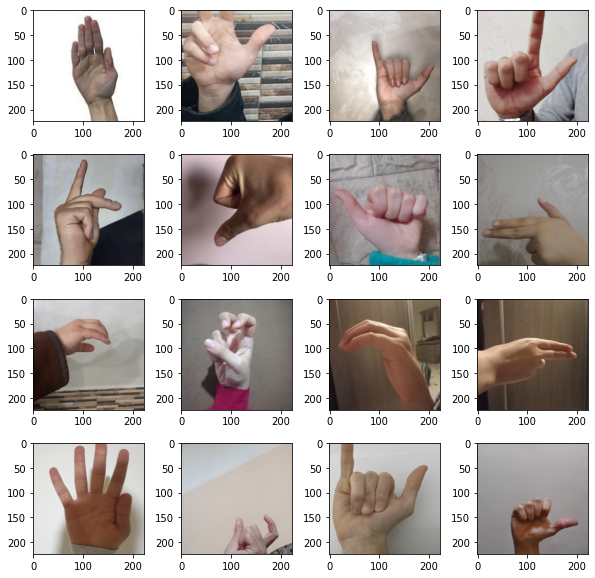

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_data[i].permute(1, 2, 0))
    # ax.axis('off')  # Turn off axis labels for each subplot

plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the spacing between subplots

plt.show()

### Add Tensorboard

In [29]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [30]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f"runs/{tensor_baord_variable}")

In [31]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image(
    f'images_{tensor_baord_variable}', img_grid)
writer.close()

In [32]:
%tensorboard --logdir="runs/{tensor_baord_variable}"

UsageError: Line magic function `%tensorboard` not found.


## Data visulization

In [33]:
from collections import Counter
import numpy as np

In [34]:
training_Targets = [] 
validation_Targets = [] 
testing_Targets = [] 

for i in X_train: 
  training_Targets.append(dataset.targets[i])

for i in X_validation: 
  validation_Targets.append(dataset.targets[i])

for i in X_test_after: 
  testing_Targets.append(dataset.targets[i])

In [35]:
C_training   = Counter(training_Targets) 
C_validation = Counter(validation_Targets)
C_testing    = Counter(testing_Targets)

In [36]:
dataset.classes

['Ain',
 'Al',
 'Alef',
 'Beh',
 'Dad',
 'Dal',
 'Feh',
 'Ghain',
 'Hah',
 'Heh',
 'Jeem',
 'Kaf',
 'Khah',
 'Laa',
 'Lam',
 'Meem',
 'Noon',
 'Qaf',
 'Reh',
 'Sad',
 'Seen',
 'Sheen',
 'Tah',
 'Teh',
 'Teh_Marbuta',
 'Thal',
 'Theh',
 'Waw',
 'Yeh',
 'Zah',
 'Zain']

#### Training dataset

Text(0.5, 0, 'Label')

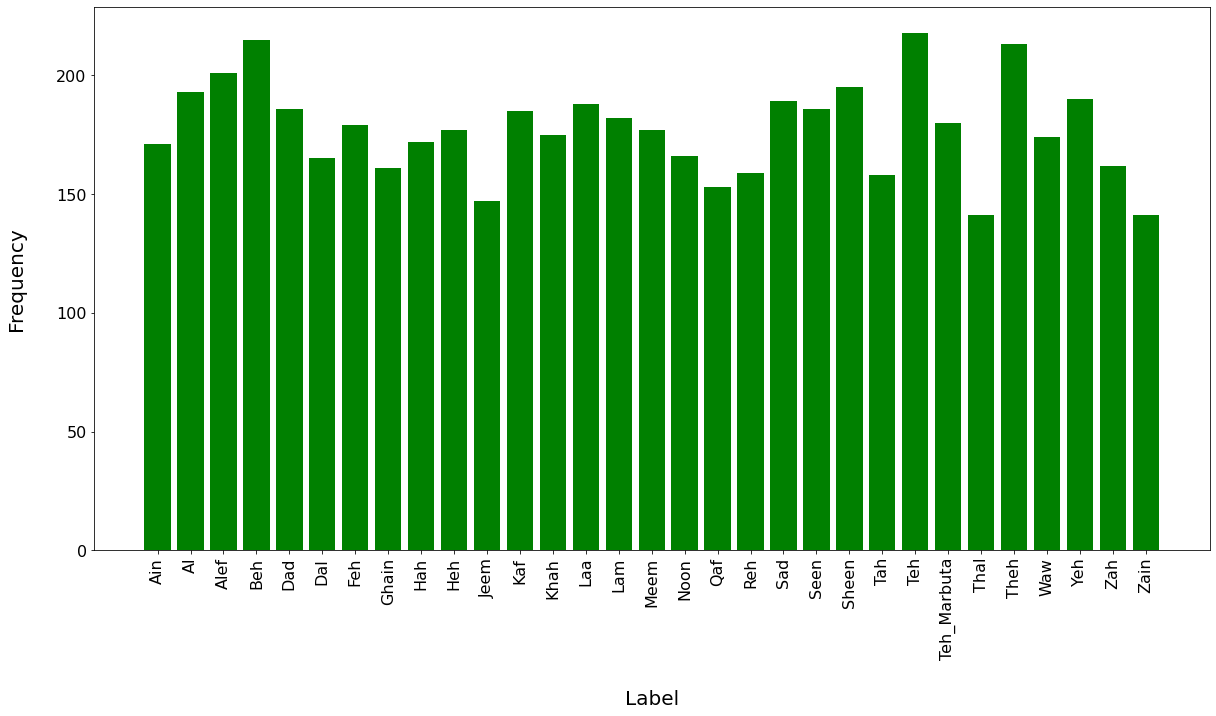

In [37]:
plt.figure(figsize=(20,10))
plt.bar(C_training.keys(), height=C_training.values(), color="green")

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);

plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Validation dataset

Text(0.5, 0, 'Label')

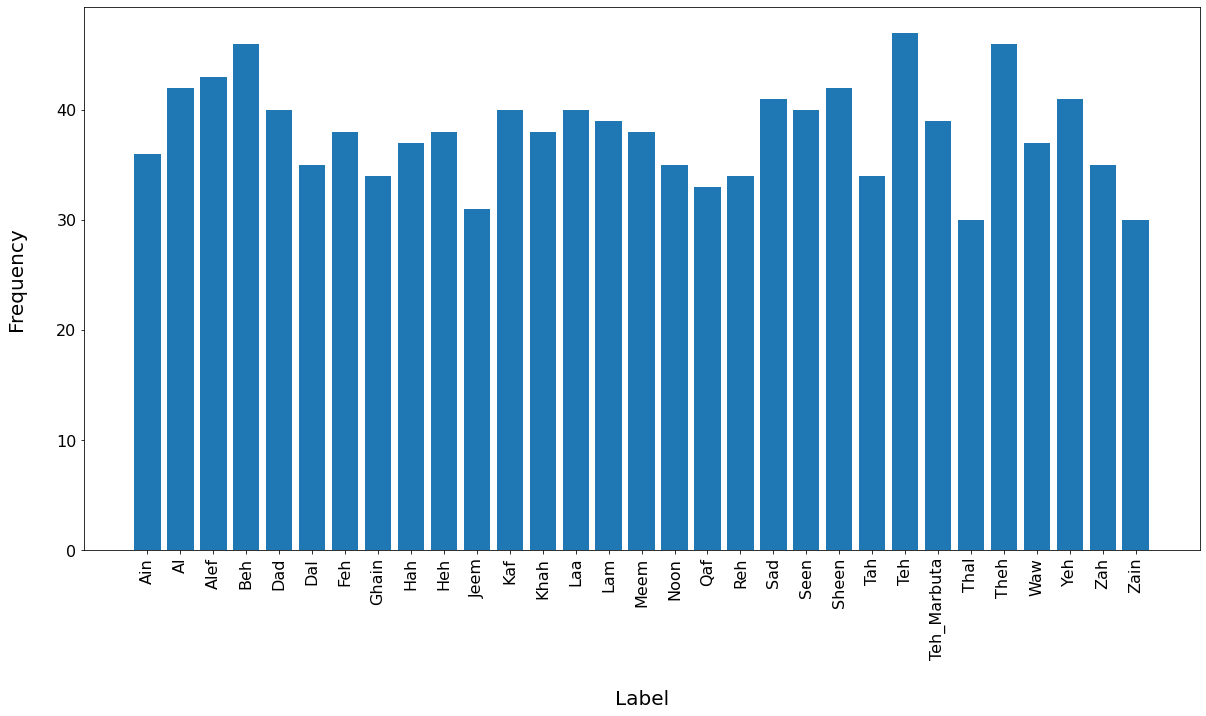

In [38]:
plt.figure(figsize=(20,10))
plt.bar(C_validation.keys(), height=C_validation.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

#### Testing Dataset

Text(0.5, 0, 'Label')

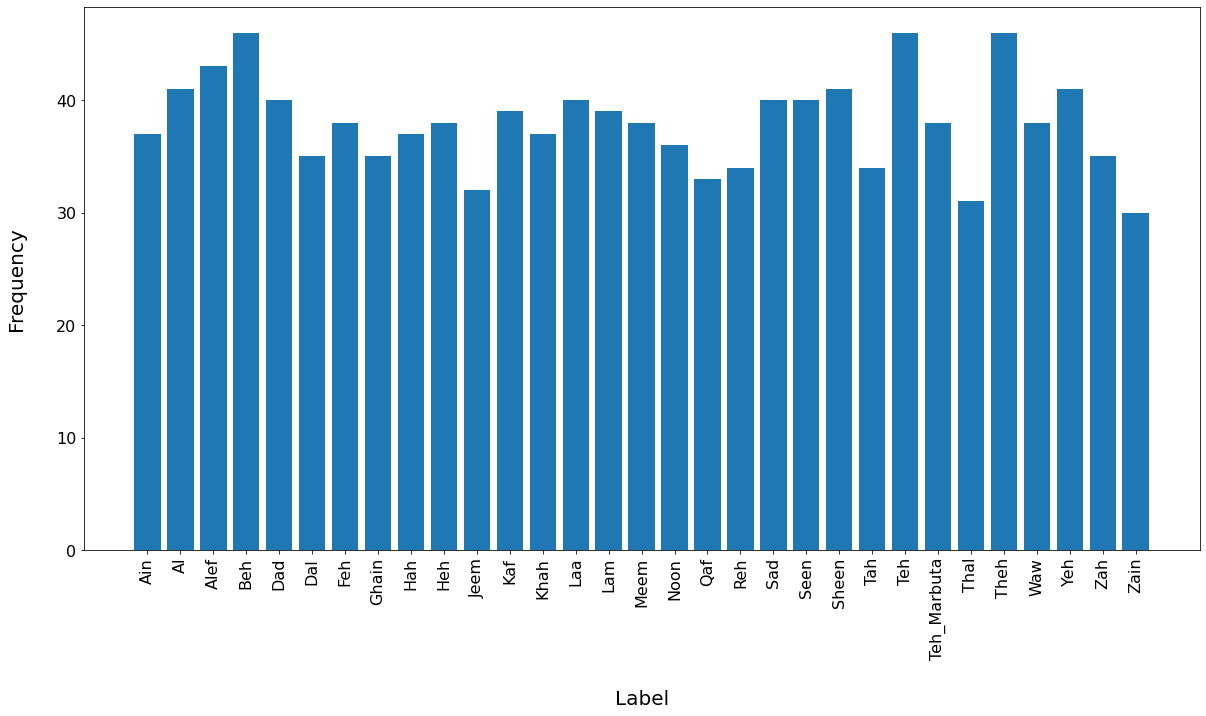

In [39]:
plt.figure(figsize=(20,10))

plt.bar(C_testing.keys(), height=C_testing.values())

tick_marks = np.arange(len(dataset.classes));

plt.xticks(tick_marks, dataset.classes, fontsize=16 , rotation=90);
plt.yticks(fontsize=16);
plt.ylabel('Frequency', fontsize=20, labelpad=30)
plt.xlabel('Label', fontsize=20, labelpad=30)

## Model Defenition

In [40]:
import torchvision.models as models
import torch.nn.functional as F

In [41]:
class Model(nn.Module):
    
    def __init__(self, in_channels=3, num_class =31):
        super(Model, self).__init__()

        # bring resnet
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features       
        self.model.fc = nn.Linear(num_ftrs, num_class)        

    def forward(self, x):
        return self.model(x)

model = Model()

In [42]:
# Move the model to the device
model.to(device)
model

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

### Check the gradient of layers of ResNet-18

In [43]:
for param in model.parameters():
    if not param.requires_grad:
        print("Freezing found on the layers")

Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found on the layers
Freezing found

## Define a Loss function and optimizer

In [44]:
# Define my Loss 

loss = nn.CrossEntropyLoss()

# Define my optimizer 

params = model.parameters()
optimzer = optim.SGD(params, lr=0.01)

optimzer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Model Training & Validation

In [45]:
from tqdm import tqdm 

### Model training & Validation

In [46]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10

In [47]:
# import EarlyStopping
from pytorchtools import EarlyStopping

In [48]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [49]:
All_end_eopch_training_loss = []
All_end_eopch_validation_loss = []

In [50]:
n_epochs = 300
accuracy, best_Acc = 0.0, 0.0, 
print_each_steps = 100
prev_avg_loss = float('inf')
 

# Batch calculations
n_total_steps = len(train_loader)
running_correct, running_loss_val, running_correct_val, training_running_loss = 0, 0.0, 0.0, 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    model.train()

    losses_training = [] 
    accuracies_tarining = []

    ###################
    # train the model #
    ###################  
    
    for i, batch in tqdm(enumerate(train_loader, 1),"Epoch # is {}".format(epoch) ,total = len(train_loader),position=0, leave=False):

        inputs, labels, _ = batch 

        # import pdb; pdb.set_trace()
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 


        logits = logits.to(device)

        # Calculate loss
        J = loss(logits,labels)

        #  re-initlize gradiants, calculate gradients, update the weights
        optimzer.zero_grad(); J.backward() ; optimzer.step()

        # 
        training_running_loss += J.item()
        # _, predicted = torch.max(logits.data, 1)
        # running_correct += (predicted == labels).sum().item()


        losses_training.append(J.item())

        running_correct += labels.eq(logits.detach().argmax(dim=1)).float().mean()
        accuracies_tarining.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
    
        # Print some information each "print_each_steps" steps 

        if i%print_each_steps ==0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i}/{n_total_steps}], Loss: {J.item():.8f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('Batch_training_loss', training_running_loss / print_each_steps, epoch * n_total_steps + i)
            running_accuracy = running_correct / print_each_steps  # 
            writer.add_scalar('Batch_training_accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            training_running_loss = 0.0
            ###################################################

    # End epoch calculations 
    End_Eopch_Training_Loss = torch.tensor(losses_training).float().mean()
    End_Eopch_Training_Acc  = torch.tensor(accuracies_tarining).float().mean()
  
    
    # Add training loss and training accuracy each epoch 
    writer.add_scalar('End_epoch_training_loss', End_Eopch_Training_Loss.item(),epoch)
    writer.add_scalar('End_epoch_training_accuracy', End_Eopch_Training_Acc.item(),epoch)


    print()
    print(f'Epoch {epoch + 1}/{n_epochs},  Step [{i}/{n_total_steps}]', end = ', ')
    print(f'Avg training loss: { End_Eopch_Training_Loss.item() : .8f}', end = ', ')
    print(f'Avg training accuracy : {End_Eopch_Training_Acc.item() : .8%}')
    print()


    
    
    ######################    
    # validate the model #
    ######################
        
    losses_validation = [] 
    accuracies_validation = []
  

    model.eval()
  
    with torch.no_grad():
        
        for batch in tqdm(val_loader, total = len(val_loader), position=0, leave=False):

            inputs, labels, _ = batch 

            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs) # logits / scores 

            logits = logits.to(device)

            J = loss(logits,labels)


            losses_validation.append(J.item())

            running_loss_val += J.item()
            losses_validation.append(J.item())


            running_correct = labels.eq(logits.detach().argmax(dim=1)).float().mean()
            accuracies_validation.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
      
        current_loss  = torch.tensor(losses_validation).float().mean()
        current_Accuracy = torch.tensor(accuracies_validation).float().mean()
                  

        writer.add_scalar('End epoch, Validation loss', running_loss_val / len(val_loader), epoch)
        running_accuracy = running_correct / len(val_loader) 
        writer.add_scalar('End epoch, Validation accuracy', running_accuracy, epoch )
        

        print()  
        print(f'Epoch {epoch + 1}', end = ', ')
        print(f'Avg validation loss: {current_loss :.8f}', end = ', ')
        print(f'Avg validation accuracy : {current_Accuracy :.8%}')
        print()



        if current_loss < prev_avg_loss:

            prev_avg_loss = current_loss

            print()
            print('The best validation Loss is ', prev_avg_loss.item())
            print('The Current Accuracy of validation is ', current_Accuracy.item() * 100)
            print()

            torch.save(model.state_dict(), path)
      
        if current_Accuracy > best_Acc :

            best_Acc = current_Accuracy

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(current_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break           
            
        # Add training loss and training accuracy each epoch 
        writer.add_scalar('End_epoch_validation_loss', torch.tensor(losses_validation).float().mean().item(),epoch)
        writer.add_scalar('End_epoch_validation_accuracy', torch.tensor(accuracies_validation).float().mean().item(),epoch)

    # End epoch, training dataset
    All_end_eopch_validation_loss.append(torch.tensor(losses_validation).float().mean().item())
    
    # End epoch, training dataset
    All_end_eopch_training_loss.append(End_Eopch_Training_Loss.item())  
    
    writer.add_scalars('Traning_Validation', {'EOP_training loss':End_Eopch_Training_Loss.item(),
                                            'EOP_Validation loss':torch.tensor(losses_validation).float().mean().item()},
                                             epoch)

    running_loss_val = 0.0 
    running_correct_val = 0
    


Epoch 1/300,  Step [86/86], Avg training loss:  3.25602198, Avg training accuracy :  11.82499006%




Epoch 1, Avg validation loss: 2.99989510, Avg validation accuracy : 24.95735884%


The best validation Loss is  2.9998950958251953
The Current Accuracy of validation is  24.957358837127686

Validation loss decreased (inf --> 2.999895).  Saving model ...



Epoch 2/300,  Step [86/86], Avg training loss:  2.79115891, Avg training accuracy :  32.11655021%




Epoch 2, Avg validation loss: 2.62441182, Avg validation accuracy : 39.47977424%


The best validation Loss is  2.6244118213653564
The Current Accuracy of validation is  39.47977423667908

Validation loss decreased (2.999895 --> 2.624412).  Saving model ...



Epoch 3/300,  Step [86/86], Avg training loss:  2.44641280, Avg training accuracy :  45.06183565%




Epoch 3, Avg validation loss: 2.34739065, Avg validation accuracy : 48.25779796%


The best validation Loss is  2.347390651702881
The Current Accuracy of validation is  48.257797956466675

Validation loss decreased (2.624412 --> 2.347391).  Saving model ...



Epoch 4/300,  Step [86/86], Avg training loss:  2.18701315, Avg training accuracy :  52.82753110%




Epoch 4, Avg validation loss: 2.13944054, Avg validation accuracy : 54.21844125%


The best validation Loss is  2.1394405364990234
The Current Accuracy of validation is  54.21844124794006

Validation loss decreased (2.347391 --> 2.139441).  Saving model ...



Epoch 5/300,  Step [86/86], Avg training loss:  1.98775566, Avg training accuracy :  58.42653513%




Epoch 5, Avg validation loss: 1.97931409, Avg validation accuracy : 57.17896819%


The best validation Loss is  1.9793140888214111
The Current Accuracy of validation is  57.17896819114685

Validation loss decreased (2.139441 --> 1.979314).  Saving model ...



Epoch 6/300,  Step [86/86], Avg training loss:  1.83078396, Avg training accuracy :  62.29953170%




Epoch 6, Avg validation loss: 1.85289538, Avg validation accuracy : 59.73744988%


The best validation Loss is  1.8528953790664673
The Current Accuracy of validation is  59.73744988441467

Validation loss decreased (1.979314 --> 1.852895).  Saving model ...



Epoch 7/300,  Step [86/86], Avg training loss:  1.70413136, Avg training accuracy :  64.97185230%




Epoch 7, Avg validation loss: 1.75086236, Avg validation accuracy : 61.79337502%


The best validation Loss is  1.7508623600006104
The Current Accuracy of validation is  61.79337501525879

Validation loss decreased (1.852895 --> 1.750862).  Saving model ...



Epoch 8/300,  Step [86/86], Avg training loss:  1.59977567, Avg training accuracy :  67.32022762%




Epoch 8, Avg validation loss: 1.66693401, Avg validation accuracy : 62.20455766%


The best validation Loss is  1.6669340133666992
The Current Accuracy of validation is  62.20455765724182

Validation loss decreased (1.750862 --> 1.666934).  Saving model ...



Epoch 9/300,  Step [86/86], Avg training loss:  1.51222622, Avg training accuracy :  69.08258200%




Epoch 9, Avg validation loss: 1.59676540, Avg validation accuracy : 63.13961744%


The best validation Loss is  1.596765398979187
The Current Accuracy of validation is  63.13961744308472

Validation loss decreased (1.666934 --> 1.596765).  Saving model ...



Epoch 10/300,  Step [86/86], Avg training loss:  1.43762994, Avg training accuracy :  70.90405822%




Epoch 10, Avg validation loss: 1.53727305, Avg validation accuracy : 64.12646174%


The best validation Loss is  1.5372730493545532
The Current Accuracy of validation is  64.12646174430847

Validation loss decreased (1.596765 --> 1.537273).  Saving model ...



Epoch 11/300,  Step [86/86], Avg training loss:  1.37321401, Avg training accuracy :  71.83219790%




Epoch 11, Avg validation loss: 1.48621595, Avg validation accuracy : 64.53764439%


The best validation Loss is  1.4862159490585327
The Current Accuracy of validation is  64.5376443862915

Validation loss decreased (1.537273 --> 1.486216).  Saving model ...



Epoch 12/300,  Step [86/86], Avg training loss:  1.31693876, Avg training accuracy :  72.92693257%




Epoch 12, Avg validation loss: 1.44193101, Avg validation accuracy : 65.47271013%


The best validation Loss is  1.4419310092926025
The Current Accuracy of validation is  65.47271013259888

Validation loss decreased (1.486216 --> 1.441931).  Saving model ...



Epoch 13/300,  Step [86/86], Avg training loss:  1.26727402, Avg training accuracy :  73.76422286%




Epoch 13, Avg validation loss: 1.40316105, Avg validation accuracy : 65.71941972%


The best validation Loss is  1.4031610488891602
The Current Accuracy of validation is  65.7194197177887

Validation loss decreased (1.441931 --> 1.403161).  Saving model ...



Epoch 14/300,  Step [86/86], Avg training loss:  1.22305000, Avg training accuracy :  74.47280288%




Epoch 14, Avg validation loss: 1.36893845, Avg validation accuracy : 66.04836583%


The best validation Loss is  1.3689384460449219
The Current Accuracy of validation is  66.04836583137512

Validation loss decreased (1.403161 --> 1.368938).  Saving model ...



Epoch 15/300,  Step [86/86], Avg training loss:  1.18335855, Avg training accuracy :  75.31009912%




Epoch 15, Avg validation loss: 1.33850825, Avg validation accuracy : 66.62402153%


The best validation Loss is  1.3385082483291626
The Current Accuracy of validation is  66.62402153015137

Validation loss decreased (1.368938 --> 1.338508).  Saving model ...



Epoch 16/300,  Step [86/86], Avg training loss:  1.14748454, Avg training accuracy :  75.90966225%




Epoch 16, Avg validation loss: 1.31127346, Avg validation accuracy : 66.70625806%


The best validation Loss is  1.311273455619812
The Current Accuracy of validation is  66.70625805854797

Validation loss decreased (1.338508 --> 1.311273).  Saving model ...



Epoch 17/300,  Step [86/86], Avg training loss:  1.11485708, Avg training accuracy :  76.47442222%




Epoch 17, Avg validation loss: 1.28675508, Avg validation accuracy : 66.78850055%


The best validation Loss is  1.286755084991455
The Current Accuracy of validation is  66.78850054740906

Validation loss decreased (1.311273 --> 1.286755).  Saving model ...



Epoch 18/300,  Step [86/86], Avg training loss:  1.08501506, Avg training accuracy :  77.03765035%




Epoch 18, Avg validation loss: 1.26456571, Avg validation accuracy : 67.19968319%


The best validation Loss is  1.2645657062530518
The Current Accuracy of validation is  67.19968318939209

Validation loss decreased (1.286755 --> 1.264566).  Saving model ...



Epoch 19/300,  Step [86/86], Avg training loss:  1.05758238, Avg training accuracy :  77.51003504%




Epoch 19, Avg validation loss: 1.24438834, Avg validation accuracy : 67.44639277%


The best validation Loss is  1.2443883419036865
The Current Accuracy of validation is  67.44639277458191

Validation loss decreased (1.264566 --> 1.244388).  Saving model ...



Epoch 20/300,  Step [86/86], Avg training loss:  1.03224862, Avg training accuracy :  77.87495255%




Epoch 20, Avg validation loss: 1.22596121, Avg validation accuracy : 67.72356629%


The best validation Loss is  1.2259612083435059
The Current Accuracy of validation is  67.72356629371643

Validation loss decreased (1.244388 --> 1.225961).  Saving model ...



Epoch 21/300,  Step [86/86], Avg training loss:  1.00875592, Avg training accuracy :  78.40183973%




Epoch 21, Avg validation loss: 1.20906579, Avg validation accuracy : 67.72356629%


The best validation Loss is  1.2090657949447632
The Current Accuracy of validation is  67.72356629371643

Validation loss decreased (1.225961 --> 1.209066).  Saving model ...



Epoch 22/300,  Step [86/86], Avg training loss:  0.98688763, Avg training accuracy :  78.94690037%




Epoch 22, Avg validation loss: 1.19351959, Avg validation accuracy : 67.88803935%


The best validation Loss is  1.1935195922851562
The Current Accuracy of validation is  67.88803935050964

Validation loss decreased (1.209066 --> 1.193520).  Saving model ...



Epoch 23/300,  Step [86/86], Avg training loss:  0.96646100, Avg training accuracy :  79.34660912%




Epoch 23, Avg validation loss: 1.17916751, Avg validation accuracy : 68.29922199%


The best validation Loss is  1.1791675090789795
The Current Accuracy of validation is  68.29922199249268

Validation loss decreased (1.193520 --> 1.179168).  Saving model ...



Epoch 24/300,  Step [86/86], Avg training loss:  0.94732034, Avg training accuracy :  79.54646349%




Epoch 24, Avg validation loss: 1.16587794, Avg validation accuracy : 68.29922199%


The best validation Loss is  1.1658779382705688
The Current Accuracy of validation is  68.29922199249268

Validation loss decreased (1.179168 --> 1.165878).  Saving model ...



Epoch 25/300,  Step [86/86], Avg training loss:  0.92933214, Avg training accuracy :  80.03701568%




Epoch 25, Avg validation loss: 1.15353799, Avg validation accuracy : 68.46369505%


The best validation Loss is  1.1535379886627197
The Current Accuracy of validation is  68.46369504928589

Validation loss decreased (1.165878 --> 1.153538).  Saving model ...



Epoch 26/300,  Step [86/86], Avg training loss:  0.91238147, Avg training accuracy :  80.36404848%




Epoch 26, Avg validation loss: 1.14205015, Avg validation accuracy : 68.62816811%


The best validation Loss is  1.1420501470565796
The Current Accuracy of validation is  68.6281681060791

Validation loss decreased (1.153538 --> 1.142050).  Saving model ...



Epoch 27/300,  Step [86/86], Avg training loss:  0.89636886, Avg training accuracy :  80.74558973%




Epoch 27, Avg validation loss: 1.13133061, Avg validation accuracy : 68.79264712%


The best validation Loss is  1.1313306093215942
The Current Accuracy of validation is  68.79264712333679

Validation loss decreased (1.142050 --> 1.131331).  Saving model ...



Epoch 28/300,  Step [86/86], Avg training loss:  0.88120759, Avg training accuracy :  81.12713099%




Epoch 28, Avg validation loss: 1.12130582, Avg validation accuracy : 68.59771013%


The best validation Loss is  1.1213058233261108
The Current Accuracy of validation is  68.59771013259888

Validation loss decreased (1.131331 --> 1.121306).  Saving model ...



Epoch 29/300,  Step [86/86], Avg training loss:  0.86682135, Avg training accuracy :  81.30881786%




Epoch 29, Avg validation loss: 1.11191154, Avg validation accuracy : 68.84441972%


The best validation Loss is  1.1119115352630615
The Current Accuracy of validation is  68.8444197177887

Validation loss decreased (1.121306 --> 1.111912).  Saving model ...



Epoch 30/300,  Step [86/86], Avg training loss:  0.85314357, Avg training accuracy :  81.49050474%




Epoch 30, Avg validation loss: 1.10309148, Avg validation accuracy : 69.17336583%


The best validation Loss is  1.1030914783477783
The Current Accuracy of validation is  69.17336583137512

Validation loss decreased (1.111912 --> 1.103091).  Saving model ...



Epoch 31/300,  Step [86/86], Avg training loss:  0.84011501, Avg training accuracy :  81.70852661%




Epoch 31, Avg validation loss: 1.09479618, Avg validation accuracy : 69.17336583%


The best validation Loss is  1.0947961807250977
The Current Accuracy of validation is  69.17336583137512

Validation loss decreased (1.103091 --> 1.094796).  Saving model ...



Epoch 32/300,  Step [86/86], Avg training loss:  0.82768357, Avg training accuracy :  81.87204599%




Epoch 32, Avg validation loss: 1.08698094, Avg validation accuracy : 69.42007542%


The best validation Loss is  1.086980938911438
The Current Accuracy of validation is  69.42007541656494

Validation loss decreased (1.094796 --> 1.086981).  Saving model ...



Epoch 33/300,  Step [86/86], Avg training loss:  0.81580240, Avg training accuracy :  82.12794662%




Epoch 33, Avg validation loss: 1.07960737, Avg validation accuracy : 69.58454847%


The best validation Loss is  1.079607367515564
The Current Accuracy of validation is  69.58454847335815

Validation loss decreased (1.086981 --> 1.079607).  Saving model ...



Epoch 34/300,  Step [86/86], Avg training loss:  0.80442989, Avg training accuracy :  82.34596848%




Epoch 34, Avg validation loss: 1.07263970, Avg validation accuracy : 69.66678500%


The best validation Loss is  1.0726397037506104
The Current Accuracy of validation is  69.66678500175476

Validation loss decreased (1.079607 --> 1.072640).  Saving model ...



Epoch 35/300,  Step [86/86], Avg training loss:  0.79352874, Avg training accuracy :  82.52765536%




Epoch 35, Avg validation loss: 1.06604695, Avg validation accuracy : 69.99573708%


The best validation Loss is  1.066046953201294
The Current Accuracy of validation is  69.99573707580566

Validation loss decreased (1.072640 --> 1.066047).  Saving model ...



Epoch 36/300,  Step [86/86], Avg training loss:  0.78306538, Avg training accuracy :  82.69117475%




Epoch 36, Avg validation loss: 1.05980146, Avg validation accuracy : 70.32468319%


The best validation Loss is  1.059801459312439
The Current Accuracy of validation is  70.32468318939209

Validation loss decreased (1.066047 --> 1.059801).  Saving model ...



Epoch 37/300,  Step [86/86], Avg training loss:  0.77300948, Avg training accuracy :  82.96370506%




Epoch 37, Avg validation loss: 1.05387712, Avg validation accuracy : 70.84856629%


The best validation Loss is  1.0538771152496338
The Current Accuracy of validation is  70.84856629371643

Validation loss decreased (1.059801 --> 1.053877).  Saving model ...



Epoch 38/300,  Step [86/86], Avg training loss:  0.76333350, Avg training accuracy :  83.12721848%




Epoch 38, Avg validation loss: 1.04825127, Avg validation accuracy : 71.01303935%


The best validation Loss is  1.0482512712478638
The Current Accuracy of validation is  71.01303935050964

Validation loss decreased (1.053877 --> 1.048251).  Saving model ...



Epoch 39/300,  Step [86/86], Avg training loss:  0.75401282, Avg training accuracy :  83.32707882%




Epoch 39, Avg validation loss: 1.04290354, Avg validation accuracy : 71.09527588%


The best validation Loss is  1.0429035425186157
The Current Accuracy of validation is  71.09527587890625

Validation loss decreased (1.048251 --> 1.042904).  Saving model ...



Epoch 40/300,  Step [86/86], Avg training loss:  0.74502456, Avg training accuracy :  83.65411162%




Epoch 40, Avg validation loss: 1.03781474, Avg validation accuracy : 71.34198546%


The best validation Loss is  1.037814736366272
The Current Accuracy of validation is  71.34198546409607

Validation loss decreased (1.042904 --> 1.037815).  Saving model ...



Epoch 41/300,  Step [86/86], Avg training loss:  0.73634815, Avg training accuracy :  83.83579850%




Epoch 41, Avg validation loss: 1.03296769, Avg validation accuracy : 71.42422199%


The best validation Loss is  1.0329676866531372
The Current Accuracy of validation is  71.42422199249268

Validation loss decreased (1.037815 --> 1.032968).  Saving model ...



Epoch 42/300,  Step [86/86], Avg training loss:  0.72796500, Avg training accuracy :  84.12649632%




Epoch 42, Avg validation loss: 1.02834737, Avg validation accuracy : 71.50645852%


The best validation Loss is  1.028347373008728
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (1.032968 --> 1.028347).  Saving model ...



Epoch 43/300,  Step [86/86], Avg training loss:  0.71985739, Avg training accuracy :  84.34451818%




Epoch 43, Avg validation loss: 1.02393866, Avg validation accuracy : 71.58869505%


The best validation Loss is  1.0239386558532715
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (1.028347 --> 1.023939).  Saving model ...



Epoch 44/300,  Step [86/86], Avg training loss:  0.71200973, Avg training accuracy :  84.52620506%




Epoch 44, Avg validation loss: 1.01972890, Avg validation accuracy : 71.50645852%


The best validation Loss is  1.0197288990020752
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (1.023939 --> 1.019729).  Saving model ...



Epoch 45/300,  Step [86/86], Avg training loss:  0.70440745, Avg training accuracy :  84.74576473%




Epoch 45, Avg validation loss: 1.01570594, Avg validation accuracy : 71.50645852%


The best validation Loss is  1.015705943107605
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (1.019729 --> 1.015706).  Saving model ...



Epoch 46/300,  Step [86/86], Avg training loss:  0.69703692, Avg training accuracy :  84.96378660%




Epoch 46, Avg validation loss: 1.01185894, Avg validation accuracy : 71.50645852%


The best validation Loss is  1.0118589401245117
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (1.015706 --> 1.011859).  Saving model ...



Epoch 47/300,  Step [86/86], Avg training loss:  0.68988591, Avg training accuracy :  85.18180847%




Epoch 47, Avg validation loss: 1.00817728, Avg validation accuracy : 71.75316811%


The best validation Loss is  1.0081772804260254
The Current Accuracy of validation is  71.7531681060791

Validation loss decreased (1.011859 --> 1.008177).  Saving model ...



Epoch 48/300,  Step [86/86], Avg training loss:  0.68294275, Avg training accuracy :  85.29081941%




Epoch 48, Avg validation loss: 1.00465190, Avg validation accuracy : 71.58869505%


The best validation Loss is  1.0046519041061401
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (1.008177 --> 1.004652).  Saving model ...



Epoch 49/300,  Step [86/86], Avg training loss:  0.67619699, Avg training accuracy :  85.43617129%




Epoch 49, Avg validation loss: 1.00127387, Avg validation accuracy : 71.58869505%


The best validation Loss is  1.0012738704681396
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (1.004652 --> 1.001274).  Saving model ...



Epoch 50/300,  Step [86/86], Avg training loss:  0.66963869, Avg training accuracy :  85.59968472%




Epoch 50, Avg validation loss: 0.99803555, Avg validation accuracy : 71.50645852%


The best validation Loss is  0.9980355501174927
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (1.001274 --> 0.998036).  Saving model ...



Epoch 51/300,  Step [86/86], Avg training loss:  0.66325855, Avg training accuracy :  85.78137159%




Epoch 51, Avg validation loss: 0.99492884, Avg validation accuracy : 71.50645852%


The best validation Loss is  0.9949288368225098
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (0.998036 --> 0.994929).  Saving model ...



Epoch 52/300,  Step [86/86], Avg training loss:  0.65704805, Avg training accuracy :  85.94489098%




Epoch 52, Avg validation loss: 0.99194700, Avg validation accuracy : 71.50645852%


The best validation Loss is  0.9919469952583313
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (0.994929 --> 0.991947).  Saving model ...



Epoch 53/300,  Step [86/86], Avg training loss:  0.65099931, Avg training accuracy :  86.12657785%




Epoch 53, Avg validation loss: 0.98908395, Avg validation accuracy : 71.50645852%


The best validation Loss is  0.9890839457511902
The Current Accuracy of validation is  71.50645852088928

Validation loss decreased (0.991947 --> 0.989084).  Saving model ...



Epoch 54/300,  Step [86/86], Avg training loss:  0.64510477, Avg training accuracy :  86.29009128%




Epoch 54, Avg validation loss: 0.98633325, Avg validation accuracy : 71.42422199%


The best validation Loss is  0.9863332509994507
The Current Accuracy of validation is  71.42422199249268

Validation loss decreased (0.989084 --> 0.986333).  Saving model ...



Epoch 55/300,  Step [86/86], Avg training loss:  0.63935751, Avg training accuracy :  86.47177815%




Epoch 55, Avg validation loss: 0.98368925, Avg validation accuracy : 71.42422199%


The best validation Loss is  0.9836892485618591
The Current Accuracy of validation is  71.42422199249268

Validation loss decreased (0.986333 --> 0.983689).  Saving model ...



Epoch 56/300,  Step [86/86], Avg training loss:  0.63375103, Avg training accuracy :  86.58078909%




Epoch 56, Avg validation loss: 0.98114699, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.9811469912528992
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.983689 --> 0.981147).  Saving model ...



Epoch 57/300,  Step [86/86], Avg training loss:  0.62827927, Avg training accuracy :  86.74430847%




Epoch 57, Avg validation loss: 0.97870141, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.9787014126777649
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.981147 --> 0.978701).  Saving model ...



Epoch 58/300,  Step [86/86], Avg training loss:  0.62293625, Avg training accuracy :  86.85331941%




Epoch 58, Avg validation loss: 0.97634774, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.9763477444648743
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.978701 --> 0.976348).  Saving model ...



Epoch 59/300,  Step [86/86], Avg training loss:  0.61771697, Avg training accuracy :  86.90782785%




Epoch 59, Avg validation loss: 0.97408193, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.9740819334983826
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.976348 --> 0.974082).  Saving model ...



Epoch 60/300,  Step [86/86], Avg training loss:  0.61261600, Avg training accuracy :  87.03500628%




Epoch 60, Avg validation loss: 0.97189993, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.9718999266624451
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.974082 --> 0.971900).  Saving model ...



Epoch 61/300,  Step [86/86], Avg training loss:  0.60762870, Avg training accuracy :  87.23639846%




Epoch 61, Avg validation loss: 0.96979773, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.9697977304458618
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.971900 --> 0.969798).  Saving model ...



Epoch 62/300,  Step [86/86], Avg training loss:  0.60275066, Avg training accuracy :  87.36357689%




Epoch 62, Avg validation loss: 0.96777201, Avg validation accuracy : 71.75316811%


The best validation Loss is  0.9677720069885254
The Current Accuracy of validation is  71.7531681060791

Validation loss decreased (0.969798 --> 0.967772).  Saving model ...



Epoch 63/300,  Step [86/86], Avg training loss:  0.59797746, Avg training accuracy :  87.59976625%




Epoch 63, Avg validation loss: 0.96581912, Avg validation accuracy : 71.75316811%


The best validation Loss is  0.9658191204071045
The Current Accuracy of validation is  71.7531681060791

Validation loss decreased (0.967772 --> 0.965819).  Saving model ...



Epoch 64/300,  Step [86/86], Avg training loss:  0.59330505, Avg training accuracy :  87.69060969%




Epoch 64, Avg validation loss: 0.96393603, Avg validation accuracy : 71.83540463%


The best validation Loss is  0.9639360308647156
The Current Accuracy of validation is  71.83540463447571

Validation loss decreased (0.965819 --> 0.963936).  Saving model ...



Epoch 65/300,  Step [86/86], Avg training loss:  0.58872986, Avg training accuracy :  87.78145313%




Epoch 65, Avg validation loss: 0.96211994, Avg validation accuracy : 71.75316811%


The best validation Loss is  0.9621199369430542
The Current Accuracy of validation is  71.7531681060791

Validation loss decreased (0.963936 --> 0.962120).  Saving model ...



Epoch 66/300,  Step [86/86], Avg training loss:  0.58424819, Avg training accuracy :  87.94497252%




Epoch 66, Avg validation loss: 0.96036762, Avg validation accuracy : 71.67093158%


The best validation Loss is  0.9603676199913025
The Current Accuracy of validation is  71.6709315776825

Validation loss decreased (0.962120 --> 0.960368).  Saving model ...



Epoch 67/300,  Step [86/86], Avg training loss:  0.57985663, Avg training accuracy :  88.01764846%




Epoch 67, Avg validation loss: 0.95867682, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.958676815032959
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.960368 --> 0.958677).  Saving model ...



Epoch 68/300,  Step [86/86], Avg training loss:  0.57555187, Avg training accuracy :  88.18116188%




Epoch 68, Avg validation loss: 0.95704478, Avg validation accuracy : 71.58869505%


The best validation Loss is  0.957044780254364
The Current Accuracy of validation is  71.58869504928589

Validation loss decreased (0.958677 --> 0.957045).  Saving model ...



Epoch 69/300,  Step [86/86], Avg training loss:  0.57133096, Avg training accuracy :  88.25383782%




Epoch 69, Avg validation loss: 0.95546901, Avg validation accuracy : 71.67093158%


The best validation Loss is  0.955469012260437
The Current Accuracy of validation is  71.6709315776825

Validation loss decreased (0.957045 --> 0.955469).  Saving model ...



Epoch 70/300,  Step [86/86], Avg training loss:  0.56719095, Avg training accuracy :  88.41735721%




Epoch 70, Avg validation loss: 0.95394766, Avg validation accuracy : 71.75316811%


The best validation Loss is  0.9539476633071899
The Current Accuracy of validation is  71.7531681060791

Validation loss decreased (0.955469 --> 0.953948).  Saving model ...



Epoch 71/300,  Step [86/86], Avg training loss:  0.56312913, Avg training accuracy :  88.50820065%




Epoch 71, Avg validation loss: 0.95247823, Avg validation accuracy : 71.75316811%


The best validation Loss is  0.9524782299995422
The Current Accuracy of validation is  71.7531681060791

Validation loss decreased (0.953948 --> 0.952478).  Saving model ...



Epoch 72/300,  Step [86/86], Avg training loss:  0.55914271, Avg training accuracy :  88.58087063%




Epoch 72, Avg validation loss: 0.95105904, Avg validation accuracy : 71.67093158%


The best validation Loss is  0.9510590434074402
The Current Accuracy of validation is  71.6709315776825

Validation loss decreased (0.952478 --> 0.951059).  Saving model ...



Epoch 73/300,  Step [86/86], Avg training loss:  0.55522949, Avg training accuracy :  88.67171407%




Epoch 73, Avg validation loss: 0.94968784, Avg validation accuracy : 71.67093158%


The best validation Loss is  0.9496878385543823
The Current Accuracy of validation is  71.6709315776825

Validation loss decreased (0.951059 --> 0.949688).  Saving model ...



Epoch 74/300,  Step [86/86], Avg training loss:  0.55138677, Avg training accuracy :  88.74439001%




Epoch 74, Avg validation loss: 0.94836265, Avg validation accuracy : 71.75316811%


The best validation Loss is  0.9483626484870911
The Current Accuracy of validation is  71.7531681060791

Validation loss decreased (0.949688 --> 0.948363).  Saving model ...



Epoch 75/300,  Step [86/86], Avg training loss:  0.54761237, Avg training accuracy :  88.87156844%




Epoch 75, Avg validation loss: 0.94708210, Avg validation accuracy : 71.83540463%


The best validation Loss is  0.9470821022987366
The Current Accuracy of validation is  71.83540463447571

Validation loss decreased (0.948363 --> 0.947082).  Saving model ...



Epoch 76/300,  Step [86/86], Avg training loss:  0.54390419, Avg training accuracy :  88.96241188%




Epoch 76, Avg validation loss: 0.94584465, Avg validation accuracy : 71.91764712%


The best validation Loss is  0.9458446502685547
The Current Accuracy of validation is  71.91764712333679

Validation loss decreased (0.947082 --> 0.945845).  Saving model ...



Epoch 77/300,  Step [86/86], Avg training loss:  0.54026014, Avg training accuracy :  89.12593126%




Epoch 77, Avg validation loss: 0.94464833, Avg validation accuracy : 71.83540463%


The best validation Loss is  0.9446483254432678
The Current Accuracy of validation is  71.83540463447571

Validation loss decreased (0.945845 --> 0.944648).  Saving model ...



Epoch 78/300,  Step [86/86], Avg training loss:  0.53667825, Avg training accuracy :  89.28945065%




Epoch 78, Avg validation loss: 0.94349188, Avg validation accuracy : 71.99988365%


The best validation Loss is  0.9434918761253357
The Current Accuracy of validation is  71.9998836517334

Validation loss decreased (0.944648 --> 0.943492).  Saving model ...



Epoch 79/300,  Step [86/86], Avg training loss:  0.53315657, Avg training accuracy :  89.39846158%




Epoch 79, Avg validation loss: 0.94237369, Avg validation accuracy : 71.99988365%


The best validation Loss is  0.9423736929893494
The Current Accuracy of validation is  71.9998836517334

Validation loss decreased (0.943492 --> 0.942374).  Saving model ...



Epoch 80/300,  Step [86/86], Avg training loss:  0.52969337, Avg training accuracy :  89.50747252%




Epoch 80, Avg validation loss: 0.94129252, Avg validation accuracy : 71.99988365%


The best validation Loss is  0.9412925243377686
The Current Accuracy of validation is  71.9998836517334

Validation loss decreased (0.942374 --> 0.941293).  Saving model ...



Epoch 81/300,  Step [86/86], Avg training loss:  0.52628690, Avg training accuracy :  89.54380751%




Epoch 81, Avg validation loss: 0.94024718, Avg validation accuracy : 72.16435671%


The best validation Loss is  0.9402471780776978
The Current Accuracy of validation is  72.16435670852661

Validation loss decreased (0.941293 --> 0.940247).  Saving model ...



Epoch 82/300,  Step [86/86], Avg training loss:  0.52293545, Avg training accuracy :  89.65281844%




Epoch 82, Avg validation loss: 0.93923628, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9392362833023071
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.940247 --> 0.939236).  Saving model ...



Epoch 83/300,  Step [86/86], Avg training loss:  0.51963753, Avg training accuracy :  89.78000283%




Epoch 83, Avg validation loss: 0.93825871, Avg validation accuracy : 72.32882977%


The best validation Loss is  0.938258707523346
The Current Accuracy of validation is  72.32882976531982

Validation loss decreased (0.939236 --> 0.938259).  Saving model ...



Epoch 84/300,  Step [86/86], Avg training loss:  0.51639152, Avg training accuracy :  89.85421658%




Epoch 84, Avg validation loss: 0.93731320, Avg validation accuracy : 72.41106629%


The best validation Loss is  0.9373131990432739
The Current Accuracy of validation is  72.41106629371643

Validation loss decreased (0.938259 --> 0.937313).  Saving model ...



Epoch 85/300,  Step [86/86], Avg training loss:  0.51319599, Avg training accuracy :  89.90872502%




Epoch 85, Avg validation loss: 0.93639886, Avg validation accuracy : 72.41106629%


The best validation Loss is  0.9363988637924194
The Current Accuracy of validation is  72.41106629371643

Validation loss decreased (0.937313 --> 0.936399).  Saving model ...



Epoch 86/300,  Step [86/86], Avg training loss:  0.51004958, Avg training accuracy :  90.03590345%




Epoch 86, Avg validation loss: 0.93551457, Avg validation accuracy : 72.41106629%


The best validation Loss is  0.9355145692825317
The Current Accuracy of validation is  72.41106629371643

Validation loss decreased (0.936399 --> 0.935515).  Saving model ...



Epoch 87/300,  Step [86/86], Avg training loss:  0.50695091, Avg training accuracy :  90.18125534%




Epoch 87, Avg validation loss: 0.93465936, Avg validation accuracy : 72.32882977%


The best validation Loss is  0.9346593618392944
The Current Accuracy of validation is  72.32882976531982

Validation loss decreased (0.935515 --> 0.934659).  Saving model ...



Epoch 88/300,  Step [86/86], Avg training loss:  0.50389868, Avg training accuracy :  90.30843377%




Epoch 88, Avg validation loss: 0.93383229, Avg validation accuracy : 72.32882977%


The best validation Loss is  0.9338322877883911
The Current Accuracy of validation is  72.32882976531982

Validation loss decreased (0.934659 --> 0.933832).  Saving model ...



Epoch 89/300,  Step [86/86], Avg training loss:  0.50089175, Avg training accuracy :  90.38110971%




Epoch 89, Avg validation loss: 0.93303239, Avg validation accuracy : 72.13389277%


The best validation Loss is  0.9330323934555054
The Current Accuracy of validation is  72.13389277458191

Validation loss decreased (0.933832 --> 0.933032).  Saving model ...



Epoch 90/300,  Step [86/86], Avg training loss:  0.49792880, Avg training accuracy :  90.39927721%




Epoch 90, Avg validation loss: 0.93225908, Avg validation accuracy : 72.13389277%


The best validation Loss is  0.9322590827941895
The Current Accuracy of validation is  72.13389277458191

Validation loss decreased (0.933032 --> 0.932259).  Saving model ...



Epoch 91/300,  Step [86/86], Avg training loss:  0.49500877, Avg training accuracy :  90.39927721%




Epoch 91, Avg validation loss: 0.93151104, Avg validation accuracy : 72.21612930%


The best validation Loss is  0.9315110445022583
The Current Accuracy of validation is  72.21612930297852

Validation loss decreased (0.932259 --> 0.931511).  Saving model ...



Epoch 92/300,  Step [86/86], Avg training loss:  0.49213049, Avg training accuracy :  90.50828815%




Epoch 92, Avg validation loss: 0.93078786, Avg validation accuracy : 72.21612930%


The best validation Loss is  0.9307878613471985
The Current Accuracy of validation is  72.21612930297852

Validation loss decreased (0.931511 --> 0.930788).  Saving model ...



Epoch 93/300,  Step [86/86], Avg training loss:  0.48929295, Avg training accuracy :  90.52645564%




Epoch 93, Avg validation loss: 0.93008864, Avg validation accuracy : 72.21612930%


The best validation Loss is  0.9300886392593384
The Current Accuracy of validation is  72.21612930297852

Validation loss decreased (0.930788 --> 0.930089).  Saving model ...



Epoch 94/300,  Step [86/86], Avg training loss:  0.48649514, Avg training accuracy :  90.56279659%




Epoch 94, Avg validation loss: 0.92941254, Avg validation accuracy : 72.13389277%


The best validation Loss is  0.9294125437736511
The Current Accuracy of validation is  72.13389277458191

Validation loss decreased (0.930089 --> 0.929413).  Saving model ...



Epoch 95/300,  Step [86/86], Avg training loss:  0.48373601, Avg training accuracy :  90.58096409%




Epoch 95, Avg validation loss: 0.92875910, Avg validation accuracy : 72.13389277%


The best validation Loss is  0.9287590980529785
The Current Accuracy of validation is  72.13389277458191

Validation loss decreased (0.929413 --> 0.928759).  Saving model ...



Epoch 96/300,  Step [86/86], Avg training loss:  0.48101464, Avg training accuracy :  90.59913158%




Epoch 96, Avg validation loss: 0.92812747, Avg validation accuracy : 72.21612930%


The best validation Loss is  0.9281274676322937
The Current Accuracy of validation is  72.21612930297852

Validation loss decreased (0.928759 --> 0.928127).  Saving model ...



Epoch 97/300,  Step [86/86], Avg training loss:  0.47833005, Avg training accuracy :  90.65363407%




Epoch 97, Avg validation loss: 0.92751694, Avg validation accuracy : 72.13389277%


The best validation Loss is  0.9275169372558594
The Current Accuracy of validation is  72.13389277458191

Validation loss decreased (0.928127 --> 0.927517).  Saving model ...



Epoch 98/300,  Step [86/86], Avg training loss:  0.47568148, Avg training accuracy :  90.72631001%




Epoch 98, Avg validation loss: 0.92692715, Avg validation accuracy : 72.29836583%


The best validation Loss is  0.9269271492958069
The Current Accuracy of validation is  72.29836583137512

Validation loss decreased (0.927517 --> 0.926927).  Saving model ...



Epoch 99/300,  Step [86/86], Avg training loss:  0.47306797, Avg training accuracy :  90.74447751%




Epoch 99, Avg validation loss: 0.92635727, Avg validation accuracy : 72.29836583%


The best validation Loss is  0.9263572692871094
The Current Accuracy of validation is  72.29836583137512

Validation loss decreased (0.926927 --> 0.926357).  Saving model ...



Epoch 100/300,  Step [86/86], Avg training loss:  0.47048876, Avg training accuracy :  90.83532095%




Epoch 100, Avg validation loss: 0.92580664, Avg validation accuracy : 72.29836583%


The best validation Loss is  0.9258066415786743
The Current Accuracy of validation is  72.29836583137512

Validation loss decreased (0.926357 --> 0.925807).  Saving model ...



Epoch 101/300,  Step [86/86], Avg training loss:  0.46794307, Avg training accuracy :  90.83532095%




Epoch 101, Avg validation loss: 0.92527509, Avg validation accuracy : 72.29836583%


The best validation Loss is  0.9252750873565674
The Current Accuracy of validation is  72.29836583137512

Validation loss decreased (0.925807 --> 0.925275).  Saving model ...



Epoch 102/300,  Step [86/86], Avg training loss:  0.46542996, Avg training accuracy :  90.85349441%




Epoch 102, Avg validation loss: 0.92476159, Avg validation accuracy : 72.29836583%


The best validation Loss is  0.9247615933418274
The Current Accuracy of validation is  72.29836583137512

Validation loss decreased (0.925275 --> 0.924762).  Saving model ...



Epoch 103/300,  Step [86/86], Avg training loss:  0.46294895, Avg training accuracy :  90.92616439%




Epoch 103, Avg validation loss: 0.92426610, Avg validation accuracy : 72.46283889%


The best validation Loss is  0.9242660999298096
The Current Accuracy of validation is  72.46283888816833

Validation loss decreased (0.924762 --> 0.924266).  Saving model ...



Epoch 104/300,  Step [86/86], Avg training loss:  0.46049911, Avg training accuracy :  90.98067284%




Epoch 104, Avg validation loss: 0.92378777, Avg validation accuracy : 72.26790786%


The best validation Loss is  0.9237877726554871
The Current Accuracy of validation is  72.2679078578949

Validation loss decreased (0.924266 --> 0.923788).  Saving model ...



Epoch 105/300,  Step [86/86], Avg training loss:  0.45807984, Avg training accuracy :  91.01700783%




Epoch 105, Avg validation loss: 0.92332637, Avg validation accuracy : 72.18567133%


The best validation Loss is  0.9233263731002808
The Current Accuracy of validation is  72.18567132949829

Validation loss decreased (0.923788 --> 0.923326).  Saving model ...



Epoch 106/300,  Step [86/86], Avg training loss:  0.45569038, Avg training accuracy :  91.16235971%




Epoch 106, Avg validation loss: 0.92288119, Avg validation accuracy : 72.18567133%


The best validation Loss is  0.9228811860084534
The Current Accuracy of validation is  72.18567132949829

Validation loss decreased (0.923326 --> 0.922881).  Saving model ...



Epoch 107/300,  Step [86/86], Avg training loss:  0.45333025, Avg training accuracy :  91.18052721%




Epoch 107, Avg validation loss: 0.92245191, Avg validation accuracy : 72.18567133%


The best validation Loss is  0.922451913356781
The Current Accuracy of validation is  72.18567132949829

Validation loss decreased (0.922881 --> 0.922452).  Saving model ...



Epoch 108/300,  Step [86/86], Avg training loss:  0.45099860, Avg training accuracy :  91.25320315%




Epoch 108, Avg validation loss: 0.92203802, Avg validation accuracy : 72.18567133%


The best validation Loss is  0.9220380187034607
The Current Accuracy of validation is  72.18567132949829

Validation loss decreased (0.922452 --> 0.922038).  Saving model ...



Epoch 109/300,  Step [86/86], Avg training loss:  0.44869497, Avg training accuracy :  91.39854908%




Epoch 109, Avg validation loss: 0.92163938, Avg validation accuracy : 72.10343480%


The best validation Loss is  0.9216393828392029
The Current Accuracy of validation is  72.10343480110168

Validation loss decreased (0.922038 --> 0.921639).  Saving model ...



Epoch 110/300,  Step [86/86], Avg training loss:  0.44641885, Avg training accuracy :  91.43488407%




Epoch 110, Avg validation loss: 0.92125511, Avg validation accuracy : 72.10343480%


The best validation Loss is  0.9212551116943359
The Current Accuracy of validation is  72.10343480110168

Validation loss decreased (0.921639 --> 0.921255).  Saving model ...



Epoch 111/300,  Step [86/86], Avg training loss:  0.44416937, Avg training accuracy :  91.45305753%




Epoch 111, Avg validation loss: 0.92088538, Avg validation accuracy : 72.02119827%


The best validation Loss is  0.9208853840827942
The Current Accuracy of validation is  72.02119827270508

Validation loss decreased (0.921255 --> 0.920885).  Saving model ...



Epoch 112/300,  Step [86/86], Avg training loss:  0.44194621, Avg training accuracy :  91.50756001%




Epoch 112, Avg validation loss: 0.92052943, Avg validation accuracy : 71.93896174%


The best validation Loss is  0.9205294251441956
The Current Accuracy of validation is  71.93896174430847

Validation loss decreased (0.920885 --> 0.920529).  Saving model ...



Epoch 113/300,  Step [86/86], Avg training loss:  0.43974876, Avg training accuracy :  91.61657095%




Epoch 113, Avg validation loss: 0.92018712, Avg validation accuracy : 71.85672522%


The best validation Loss is  0.9201871156692505
The Current Accuracy of validation is  71.85672521591187

Validation loss decreased (0.920529 --> 0.920187).  Saving model ...



Epoch 114/300,  Step [86/86], Avg training loss:  0.43757641, Avg training accuracy :  91.67107940%




Epoch 114, Avg validation loss: 0.91985780, Avg validation accuracy : 71.85672522%


The best validation Loss is  0.9198578000068665
The Current Accuracy of validation is  71.85672521591187

Validation loss decreased (0.920187 --> 0.919858).  Saving model ...



Epoch 115/300,  Step [86/86], Avg training loss:  0.43542889, Avg training accuracy :  91.74375534%




Epoch 115, Avg validation loss: 0.91954154, Avg validation accuracy : 71.85672522%


The best validation Loss is  0.9195415377616882
The Current Accuracy of validation is  71.85672521591187

Validation loss decreased (0.919858 --> 0.919542).  Saving model ...



Epoch 116/300,  Step [86/86], Avg training loss:  0.43330547, Avg training accuracy :  91.83459878%




Epoch 116, Avg validation loss: 0.91923755, Avg validation accuracy : 71.85672522%


The best validation Loss is  0.9192375540733337
The Current Accuracy of validation is  71.85672521591187

Validation loss decreased (0.919542 --> 0.919238).  Saving model ...



Epoch 117/300,  Step [86/86], Avg training loss:  0.43120575, Avg training accuracy :  91.87093377%




Epoch 117, Avg validation loss: 0.91894573, Avg validation accuracy : 71.77448869%


The best validation Loss is  0.9189457297325134
The Current Accuracy of validation is  71.77448868751526

Validation loss decreased (0.919238 --> 0.918946).  Saving model ...



Epoch 118/300,  Step [86/86], Avg training loss:  0.42912930, Avg training accuracy :  91.94360971%




Epoch 118, Avg validation loss: 0.91866606, Avg validation accuracy : 71.77448869%


The best validation Loss is  0.9186660647392273
The Current Accuracy of validation is  71.77448868751526

Validation loss decreased (0.918946 --> 0.918666).  Saving model ...



Epoch 119/300,  Step [86/86], Avg training loss:  0.42707568, Avg training accuracy :  92.03445315%




Epoch 119, Avg validation loss: 0.91839778, Avg validation accuracy : 71.96941972%


The best validation Loss is  0.9183977842330933
The Current Accuracy of validation is  71.9694197177887

Validation loss decreased (0.918666 --> 0.918398).  Saving model ...



Epoch 120/300,  Step [86/86], Avg training loss:  0.42504430, Avg training accuracy :  92.08895564%




Epoch 120, Avg validation loss: 0.91814089, Avg validation accuracy : 71.96941972%


The best validation Loss is  0.9181408882141113
The Current Accuracy of validation is  71.9694197177887

Validation loss decreased (0.918398 --> 0.918141).  Saving model ...



Epoch 121/300,  Step [86/86], Avg training loss:  0.42303494, Avg training accuracy :  92.10712314%




Epoch 121, Avg validation loss: 0.91789514, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9178951382637024
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.918141 --> 0.917895).  Saving model ...



Epoch 122/300,  Step [86/86], Avg training loss:  0.42104703, Avg training accuracy :  92.14346409%




Epoch 122, Avg validation loss: 0.91765994, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9176599383354187
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.917895 --> 0.917660).  Saving model ...



Epoch 123/300,  Step [86/86], Avg training loss:  0.41908029, Avg training accuracy :  92.16163158%




Epoch 123, Avg validation loss: 0.91743547, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9174354672431946
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.917660 --> 0.917435).  Saving model ...



Epoch 124/300,  Step [86/86], Avg training loss:  0.41713417, Avg training accuracy :  92.21613407%




Epoch 124, Avg validation loss: 0.91722107, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9172210693359375
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.917435 --> 0.917221).  Saving model ...



Epoch 125/300,  Step [86/86], Avg training loss:  0.41520843, Avg training accuracy :  92.29035378%




Epoch 125, Avg validation loss: 0.91701680, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9170168042182922
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.917221 --> 0.917017).  Saving model ...



Epoch 126/300,  Step [86/86], Avg training loss:  0.41330263, Avg training accuracy :  92.34486222%




Epoch 126, Avg validation loss: 0.91682214, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9168221354484558
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.917017 --> 0.916822).  Saving model ...



Epoch 127/300,  Step [86/86], Avg training loss:  0.41141644, Avg training accuracy :  92.34486222%




Epoch 127, Avg validation loss: 0.91663724, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9166372418403625
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.916822 --> 0.916637).  Saving model ...



Epoch 128/300,  Step [86/86], Avg training loss:  0.40954944, Avg training accuracy :  92.43570566%




Epoch 128, Avg validation loss: 0.91646153, Avg validation accuracy : 72.05165625%


The best validation Loss is  0.9164615273475647
The Current Accuracy of validation is  72.0516562461853

Validation loss decreased (0.916637 --> 0.916462).  Saving model ...



Epoch 129/300,  Step [86/86], Avg training loss:  0.40770140, Avg training accuracy :  92.50837564%




Epoch 129, Avg validation loss: 0.91629511, Avg validation accuracy : 71.96941972%


The best validation Loss is  0.9162951111793518
The Current Accuracy of validation is  71.9694197177887

Validation loss decreased (0.916462 --> 0.916295).  Saving model ...



Epoch 130/300,  Step [86/86], Avg training loss:  0.40587190, Avg training accuracy :  92.54471660%




Epoch 130, Avg validation loss: 0.91613722, Avg validation accuracy : 72.16435671%


The best validation Loss is  0.9161372184753418
The Current Accuracy of validation is  72.16435670852661

Validation loss decreased (0.916295 --> 0.916137).  Saving model ...



Epoch 131/300,  Step [86/86], Avg training loss:  0.40406063, Avg training accuracy :  92.58105159%




Epoch 131, Avg validation loss: 0.91598821, Avg validation accuracy : 72.16435671%


The best validation Loss is  0.9159882068634033
The Current Accuracy of validation is  72.16435670852661

Validation loss decreased (0.916137 --> 0.915988).  Saving model ...



Epoch 132/300,  Step [86/86], Avg training loss:  0.40226734, Avg training accuracy :  92.58105159%




Epoch 132, Avg validation loss: 0.91584778, Avg validation accuracy : 72.16435671%


The best validation Loss is  0.9158477783203125
The Current Accuracy of validation is  72.16435670852661

Validation loss decreased (0.915988 --> 0.915848).  Saving model ...



Epoch 133/300,  Step [86/86], Avg training loss:  0.40049160, Avg training accuracy :  92.58105159%




Epoch 133, Avg validation loss: 0.91571558, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9157155752182007
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.915848 --> 0.915716).  Saving model ...



Epoch 134/300,  Step [86/86], Avg training loss:  0.39873317, Avg training accuracy :  92.65372753%




Epoch 134, Avg validation loss: 0.91559142, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9155914187431335
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.915716 --> 0.915591).  Saving model ...



Epoch 135/300,  Step [86/86], Avg training loss:  0.39699185, Avg training accuracy :  92.70823002%




Epoch 135, Avg validation loss: 0.91547537, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9154753684997559
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.915591 --> 0.915475).  Saving model ...



Epoch 136/300,  Step [86/86], Avg training loss:  0.39526719, Avg training accuracy :  92.72640347%




Epoch 136, Avg validation loss: 0.91536695, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9153669476509094
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.915475 --> 0.915367).  Saving model ...



Epoch 137/300,  Step [86/86], Avg training loss:  0.39355898, Avg training accuracy :  92.78090596%




Epoch 137, Avg validation loss: 0.91526604, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9152660369873047
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.915367 --> 0.915266).  Saving model ...



Epoch 138/300,  Step [86/86], Avg training loss:  0.39186698, Avg training accuracy :  92.81724691%




Epoch 138, Avg validation loss: 0.91517258, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9151725769042969
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.915266 --> 0.915173).  Saving model ...



Epoch 139/300,  Step [86/86], Avg training loss:  0.39019084, Avg training accuracy :  92.85358191%




Epoch 139, Avg validation loss: 0.91508645, Avg validation accuracy : 72.24659324%


The best validation Loss is  0.9150864481925964
The Current Accuracy of validation is  72.24659323692322

Validation loss decreased (0.915173 --> 0.915086).  Saving model ...



Epoch 140/300,  Step [86/86], Avg training loss:  0.38853043, Avg training accuracy :  92.85358191%




Epoch 140, Avg validation loss: 0.91500735, Avg validation accuracy : 72.32882977%


The best validation Loss is  0.9150073528289795
The Current Accuracy of validation is  72.32882976531982

Validation loss decreased (0.915086 --> 0.915007).  Saving model ...



Epoch 141/300,  Step [86/86], Avg training loss:  0.38688540, Avg training accuracy :  92.90809035%




Epoch 141, Avg validation loss: 0.91493535, Avg validation accuracy : 72.32882977%


The best validation Loss is  0.9149353504180908
The Current Accuracy of validation is  72.32882976531982

Validation loss decreased (0.915007 --> 0.914935).  Saving model ...



Epoch 142/300,  Step [86/86], Avg training loss:  0.38525546, Avg training accuracy :  92.96259284%




Epoch 142, Avg validation loss: 0.91486990, Avg validation accuracy : 72.41106629%


The best validation Loss is  0.9148699045181274
The Current Accuracy of validation is  72.41106629371643

Validation loss decreased (0.914935 --> 0.914870).  Saving model ...



Epoch 143/300,  Step [86/86], Avg training loss:  0.38364047, Avg training accuracy :  93.01710129%




Epoch 143, Avg validation loss: 0.91481137, Avg validation accuracy : 72.49330282%


The best validation Loss is  0.914811372756958
The Current Accuracy of validation is  72.49330282211304

Validation loss decreased (0.914870 --> 0.914811).  Saving model ...



Epoch 144/300,  Step [86/86], Avg training loss:  0.38204014, Avg training accuracy :  93.07160378%




Epoch 144, Avg validation loss: 0.91475928, Avg validation accuracy : 72.57553935%


The best validation Loss is  0.9147592782974243
The Current Accuracy of validation is  72.57553935050964

Validation loss decreased (0.914811 --> 0.914759).  Saving model ...



Epoch 145/300,  Step [86/86], Avg training loss:  0.38045436, Avg training accuracy :  93.10794473%




Epoch 145, Avg validation loss: 0.91471350, Avg validation accuracy : 72.49330282%


The best validation Loss is  0.9147135019302368
The Current Accuracy of validation is  72.49330282211304

Validation loss decreased (0.914759 --> 0.914714).  Saving model ...



Epoch 146/300,  Step [86/86], Avg training loss:  0.37888274, Avg training accuracy :  93.12611222%




Epoch 146, Avg validation loss: 0.91467398, Avg validation accuracy : 72.57553935%


The best validation Loss is  0.9146739840507507
The Current Accuracy of validation is  72.57553935050964

Validation loss decreased (0.914714 --> 0.914674).  Saving model ...



Epoch 147/300,  Step [86/86], Avg training loss:  0.37732509, Avg training accuracy :  93.14427972%




Epoch 147, Avg validation loss: 0.91464055, Avg validation accuracy : 72.57553935%


The best validation Loss is  0.9146405458450317
The Current Accuracy of validation is  72.57553935050964

Validation loss decreased (0.914674 --> 0.914641).  Saving model ...



Epoch 148/300,  Step [86/86], Avg training loss:  0.37578121, Avg training accuracy :  93.21695566%




Epoch 148, Avg validation loss: 0.91461313, Avg validation accuracy : 72.49330282%


The best validation Loss is  0.9146131277084351
The Current Accuracy of validation is  72.49330282211304

Validation loss decreased (0.914641 --> 0.914613).  Saving model ...



Epoch 149/300,  Step [86/86], Avg training loss:  0.37425098, Avg training accuracy :  93.25329065%




Epoch 149, Avg validation loss: 0.91459155, Avg validation accuracy : 72.49330282%


The best validation Loss is  0.9145915508270264
The Current Accuracy of validation is  72.49330282211304

Validation loss decreased (0.914613 --> 0.914592).  Saving model ...



Epoch 150/300,  Step [86/86], Avg training loss:  0.37273404, Avg training accuracy :  93.32596660%




Epoch 150, Avg validation loss: 0.91457576, Avg validation accuracy : 72.65777588%


The best validation Loss is  0.9145757555961609
The Current Accuracy of validation is  72.65777587890625

Validation loss decreased (0.914592 --> 0.914576).  Saving model ...



Epoch 151/300,  Step [86/86], Avg training loss:  0.37123033, Avg training accuracy :  93.36230159%




Epoch 151, Avg validation loss: 0.91456562, Avg validation accuracy : 72.65777588%


The best validation Loss is  0.9145656228065491
The Current Accuracy of validation is  72.65777587890625

Validation loss decreased (0.914576 --> 0.914566).  Saving model ...



Epoch 152/300,  Step [86/86], Avg training loss:  0.36973956, Avg training accuracy :  93.48948002%




Epoch 152, Avg validation loss: 0.91456091, Avg validation accuracy : 72.82224894%


The best validation Loss is  0.9145609140396118
The Current Accuracy of validation is  72.82224893569946

Validation loss decreased (0.914566 --> 0.914561).  Saving model ...



Epoch 153/300,  Step [86/86], Avg training loss:  0.36826164, Avg training accuracy :  93.50765347%




Epoch 153, Avg validation loss: 0.91456163, Avg validation accuracy : 72.74001241%

EarlyStopping counter: 1 out of 10



Epoch 154/300,  Step [86/86], Avg training loss:  0.36679623, Avg training accuracy :  93.56215596%




Epoch 154, Avg validation loss: 0.91456777, Avg validation accuracy : 72.74001241%

EarlyStopping counter: 2 out of 10



Epoch 155/300,  Step [86/86], Avg training loss:  0.36534321, Avg training accuracy :  93.58032346%




Epoch 155, Avg validation loss: 0.91457891, Avg validation accuracy : 72.74001241%

EarlyStopping counter: 3 out of 10



Epoch 156/300,  Step [86/86], Avg training loss:  0.36390257, Avg training accuracy :  93.59849691%




Epoch 156, Avg validation loss: 0.91459525, Avg validation accuracy : 72.82224894%

EarlyStopping counter: 4 out of 10



Epoch 157/300,  Step [86/86], Avg training loss:  0.36247388, Avg training accuracy :  93.65299940%




Epoch 157, Avg validation loss: 0.91461653, Avg validation accuracy : 72.74001241%

EarlyStopping counter: 5 out of 10



Epoch 158/300,  Step [86/86], Avg training loss:  0.36105707, Avg training accuracy :  93.67116690%




Epoch 158, Avg validation loss: 0.91464251, Avg validation accuracy : 72.65777588%

EarlyStopping counter: 6 out of 10



Epoch 159/300,  Step [86/86], Avg training loss:  0.35965195, Avg training accuracy :  93.68934035%




Epoch 159, Avg validation loss: 0.91467357, Avg validation accuracy : 72.57553935%

EarlyStopping counter: 7 out of 10



Epoch 160/300,  Step [86/86], Avg training loss:  0.35825846, Avg training accuracy :  93.70750785%




Epoch 160, Avg validation loss: 0.91470927, Avg validation accuracy : 72.57553935%

EarlyStopping counter: 8 out of 10



Epoch 161/300,  Step [86/86], Avg training loss:  0.35687625, Avg training accuracy :  93.74384284%




Epoch 161, Avg validation loss: 0.91474944, Avg validation accuracy : 72.49330282%

EarlyStopping counter: 9 out of 10



Epoch 162/300,  Step [86/86], Avg training loss:  0.35550535, Avg training accuracy :  93.81651878%




Epoch 162, Avg validation loss: 0.91479421, Avg validation accuracy : 72.49330282%

EarlyStopping counter: 10 out of 10
Early stopping


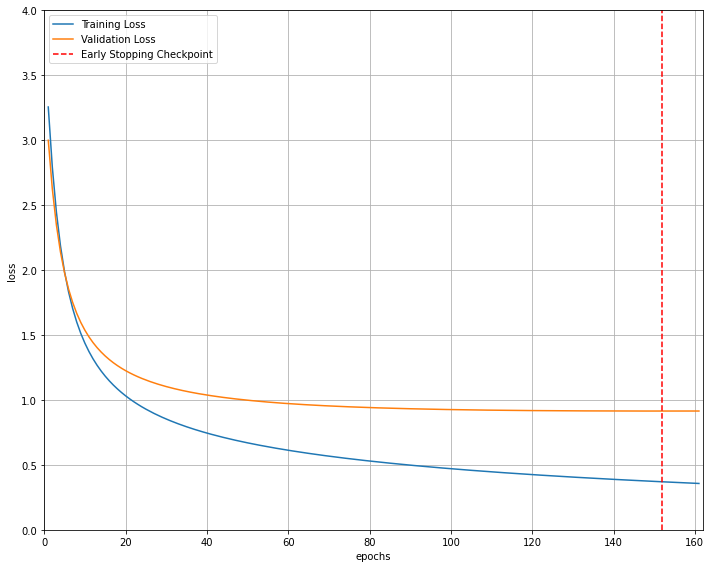

In [51]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(All_end_eopch_training_loss)+1),All_end_eopch_training_loss, label='Training Loss')
plt.plot(range(1,len(All_end_eopch_validation_loss)+1),All_end_eopch_validation_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = All_end_eopch_validation_loss.index(min(All_end_eopch_validation_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 4) # consistent scale
plt.xlim(0, len(All_end_eopch_training_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Model testing

In [52]:

model = Model().to(device)
model.load_state_dict(torch.load(path))

print("path >> ", path)

path >>  CheckPoints/Resnet_18_4


### Testing loop

In [53]:
fault_images = []
count = 0 

true = []
pred = []
pred_wrong = []
true_wrong = []
image = [] 

In [54]:
losses_testing = [] 
accuracies_testing = []
labels_list = [] 
logits_list = [] 

model.eval()

index = 0

with torch.no_grad():

    for i,batch in tqdm(enumerate(test_loader, 1), total = len(test_loader), position=0, leave=False):
        
        
        inputs, labels, paths = batch

        inputs = inputs.to(device)
    
        labels = labels.to(device)

        logits = model(inputs) # logits / scores 

        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().argmax(dim=1).numpy())

        predicted_labels = logits.cpu().detach().argmax(dim=1).numpy() # list of indices
        logits = logits.to(device)

        J = loss(logits,labels)


        loss_every_batch = J.item()
        losses_testing.append(loss_every_batch)
        

        acc = labels.eq(logits.detach().argmax(dim=1)).float().mean()
        check_it = (logits.detach().argmax(dim=1) != labels).nonzero()

     
        if len(check_it) != 0:
            idicies = check_it.cpu().numpy()
            
            for idx in idicies:
                for ele in idx:
                    fault_images.append([inputs[ele], predicted_labels[ele], labels[ele].item(), paths[ele]])
                    count += 1

        accuracies_testing.append(acc)      
        
        
        
        for i in range(len(predicted_labels)):
            pred.append(predicted_labels[i])
            true.append(labels[i].item())
            if(predicted_labels[i]!=labels[i]):
                pred_wrong.append(predicted_labels[i])
                true_wrong.append(labels[i].item())

        writer.add_scalar("Batch, Testing, loss",loss_every_batch, i)
        writer.add_scalar("Batch, Testing, accuracy",acc, i)

    print()
    print(f'Avg testing loss: {torch.tensor(losses_testing).mean():.5f}', end = ', ')
    print(f'Avg testing accuracy : {torch.tensor(accuracies_testing).float().mean()*100}%')
    print()


Avg testing loss: 0.94280, Avg testing accuracy : 70.75531768798828%



In [55]:
from sklearn import metrics


In [56]:
def performance_matrix(true,pred, type_met):
    precision = metrics.precision_score(true,pred,average=type_met)
    recall = metrics.recall_score(true,pred,average=type_met)
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average=type_met)
    print('Confusion Matrix:\n',metrics.confusion_matrix(true, pred))
    print('Precision: {} \n Recall: {}, \n Accuracy: {}: ,\n f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [57]:
performance_matrix(true,pred, 'macro')

Confusion Matrix:
 [[29  0  0  0  1  0  1  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  1  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0  0  0  0  0  3  1  1  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 40  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  3 32  0  0  1  1  0  1  0  1  0  1  0  1  0  0  0  0  0  0  0  4
   1  0  0  0  0  0  0]
 [ 0  0  0  0 33  1  0  0  0  0  0  0  0  0  1  0  0  0  0  4  0  1  0  0
   0  0  0  0  0  0  0]
 [ 0  0  1  0  1 20  1  0  0  0  2  0  0  0  0  0  0  0  5  0  0  0  1  1
   0  2  0  0  1  0  0]
 [ 0  0  0  0  0  1 22  0  0  1  0  0  1  0  0  3  1  3  2  3  0  0  0  0
   0  0  0  0  1  0  0]
 [ 5  0  2  0  0  2  0 23  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 2  0  0  0  0  1  0  0 23  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  1  0]
 [ 0  0  0  0  1  0  1  0  0 30  0  0  0  0  0  0  0  4  0  0  0  0  0  0
   2  0  0  0  0  0  0]
 

In [58]:
performance_matrix(true,pred, 'micro')

Confusion Matrix:
 [[29  0  0  0  1  0  1  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  1  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0  0  0  0  0  3  1  1  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 40  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  3 32  0  0  1  1  0  1  0  1  0  1  0  1  0  0  0  0  0  0  0  4
   1  0  0  0  0  0  0]
 [ 0  0  0  0 33  1  0  0  0  0  0  0  0  0  1  0  0  0  0  4  0  1  0  0
   0  0  0  0  0  0  0]
 [ 0  0  1  0  1 20  1  0  0  0  2  0  0  0  0  0  0  0  5  0  0  0  1  1
   0  2  0  0  1  0  0]
 [ 0  0  0  0  0  1 22  0  0  1  0  0  1  0  0  3  1  3  2  3  0  0  0  0
   0  0  0  0  1  0  0]
 [ 5  0  2  0  0  2  0 23  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 2  0  0  0  0  1  0  0 23  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  1  0]
 [ 0  0  0  0  1  0  1  0  0 30  0  0  0  0  0  0  0  4  0  0  0  0  0  0
   2  0  0  0  0  0  0]
 

In [59]:
performance_matrix(true,pred, None)

Confusion Matrix:
 [[29  0  0  0  1  0  1  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  1  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0  0  0  0  0  3  1  1  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 40  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  3 32  0  0  1  1  0  1  0  1  0  1  0  1  0  0  0  0  0  0  0  4
   1  0  0  0  0  0  0]
 [ 0  0  0  0 33  1  0  0  0  0  0  0  0  0  1  0  0  0  0  4  0  1  0  0
   0  0  0  0  0  0  0]
 [ 0  0  1  0  1 20  1  0  0  0  2  0  0  0  0  0  0  0  5  0  0  0  1  1
   0  2  0  0  1  0  0]
 [ 0  0  0  0  0  1 22  0  0  1  0  0  1  0  0  3  1  3  2  3  0  0  0  0
   0  0  0  0  1  0  0]
 [ 5  0  2  0  0  2  0 23  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 2  0  0  0  0  1  0  0 23  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  1  0]
 [ 0  0  0  0  1  0  1  0  0 30  0  0  0  0  0  0  0  4  0  0  0  0  0  0
   2  0  0  0  0  0  0]
 

In [60]:
performance_matrix(true,pred, "weighted")

Confusion Matrix:
 [[29  0  0  0  1  0  1  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  1  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0  0  0  0  0  3  1  1  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 40  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  3 32  0  0  1  1  0  1  0  1  0  1  0  1  0  0  0  0  0  0  0  4
   1  0  0  0  0  0  0]
 [ 0  0  0  0 33  1  0  0  0  0  0  0  0  0  1  0  0  0  0  4  0  1  0  0
   0  0  0  0  0  0  0]
 [ 0  0  1  0  1 20  1  0  0  0  2  0  0  0  0  0  0  0  5  0  0  0  1  1
   0  2  0  0  1  0  0]
 [ 0  0  0  0  0  1 22  0  0  1  0  0  1  0  0  3  1  3  2  3  0  0  0  0
   0  0  0  0  1  0  0]
 [ 5  0  2  0  0  2  0 23  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 2  0  0  0  0  1  0  0 23  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  1  0]
 [ 0  0  0  0  1  0  1  0  0 30  0  0  0  0  0  0  0  4  0  0  0  0  0  0
   2  0  0  0  0  0  0]
 

In [61]:
count

341

In [62]:
len(fault_images)
# , predicted_labels[ele], labels[ele].item()

341

In [63]:
traindataset.dataset.class_to_idx ;
idx2label = {idx:val for val, idx in traindataset.dataset.class_to_idx.items()}

In [64]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [65]:
!ls

 ArSL_Journal_alexnet_SGD_001_freezing.ipynb	 CM_alexnet_3
 ArSL_Journal_alexnet_SGD_001.ipynb		 CM_alexnet_4
 ArSL_Journal_alexnet_SGD_01_freezing.ipynb	 CM_Resnet_18_1
 ArSL_Journal_alexnet_SGD_01.ipynb		 CM_Resnet_18_2
'ArSL_Journal_Resnet18_01_freezing copy.ipynb'	 CM_Resnet_18_3
 ArSL_Journal_Resnet18_01_freezing.ipynb	 CM_squeezenet_1
 ArSL_Journal_Resnet18_01.ipynb			 CM_squeezenet_2
 ArSL_Journal_Resnet18_SGD_001.ipynb		 CM_squeezenet_3
 ArSL_Journal_squeezenet_001_freezing.ipynb	 CM_squeezenet_4
 ArSL_Journal_squeezenet_001.ipynb		 CM_VGG16_1
 ArSL_Journal_squeezenet_01_freezing.ipynb	 CM_VGG16_2
 ArSL_Journal_squeezenet_01.ipynb		 CM_VGG16_4
 ArSL_Journal_VGG16_001_freezing.ipynb		'Final Data Version'
 ArSL_Journal_VGG16_001.ipynb			 images
 ArSL_Journal_VGG16_01_freezing.ipynb		 loss_plot.png
 ArSL_Journal_VGG16_01.ipynb			 __pycache__
 checkpoint.pt					 pytorchtools.py
 CheckPoints					 requirements.txt
 CM_alexnet_1					 runs


### Print fault images

In [66]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images):
    name_image = f"P_{idx2label[fault_images[i][1]]}_T_{idx2label[fault_images[i][2]]}_{i}.png"
    print(name_image)
    print(fault_images[i][3])
    # plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    # plt.savefig("images/" + name_image, format="png", bbox_inches='tight') # , dpi=400
    # plt.title(name_image)


P_Sad_T_Dad_0.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Dad/Dad_98.jpg
P_Waw_T_Jeem_1.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Jeem/Jeem_30.jpg
P_Teh_T_Teh_Marbuta_2.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Teh_Marbuta/Teh_Marbuta_44.jpg
P_Tah_T_Zah_3.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Zah/Zah_221.jpg
P_Zain_T_Thal_4.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Thal/thal_169.jpg
P_Jeem_T_Teh_5.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Teh/Teh_98.jpg
P_Seen_T_Reh_6.png
/home/lenovo/Desktop/Barham/Journal_Sign_Language/Journal Work/Main Notebooks/Final Data Version/Reh/Reh_99.jpeg
P_Noon_T_Teh_Marbuta_7.png
/home/lenovo/Desktop/Barham

<Figure size 1224x1224 with 0 Axes>

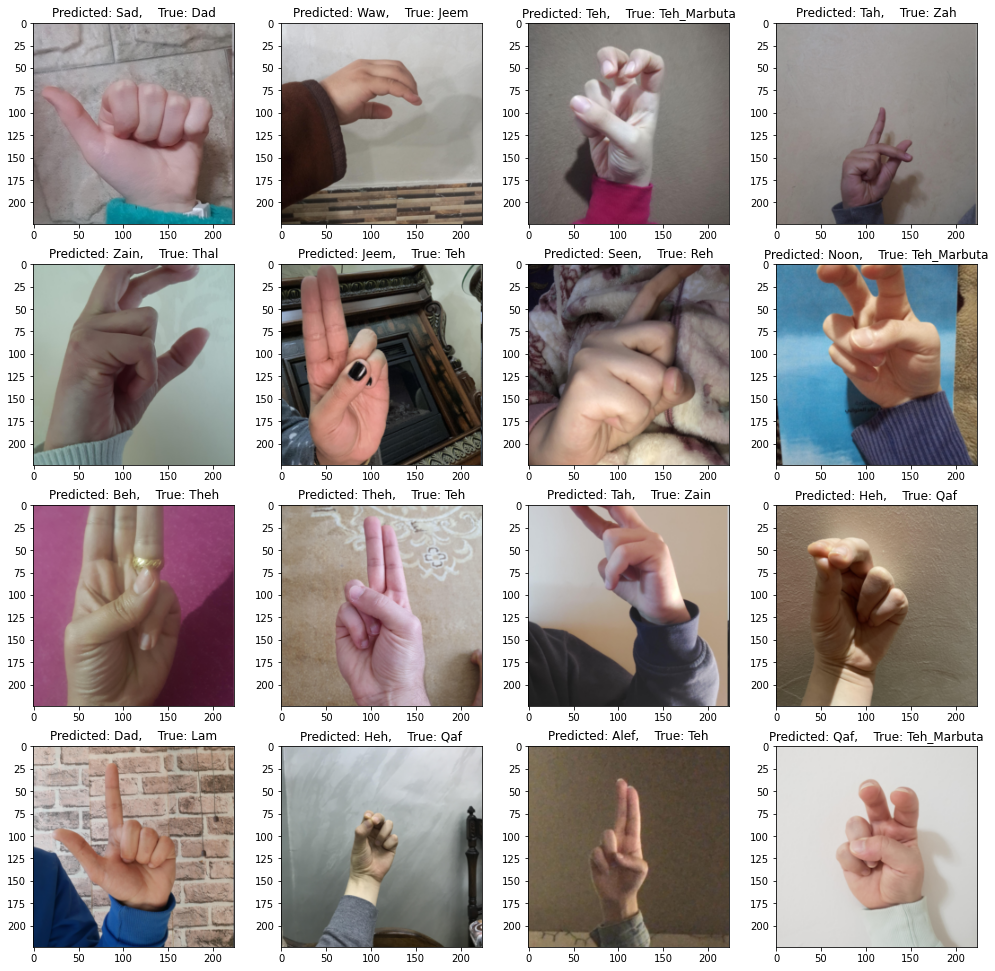

In [67]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[0:16]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


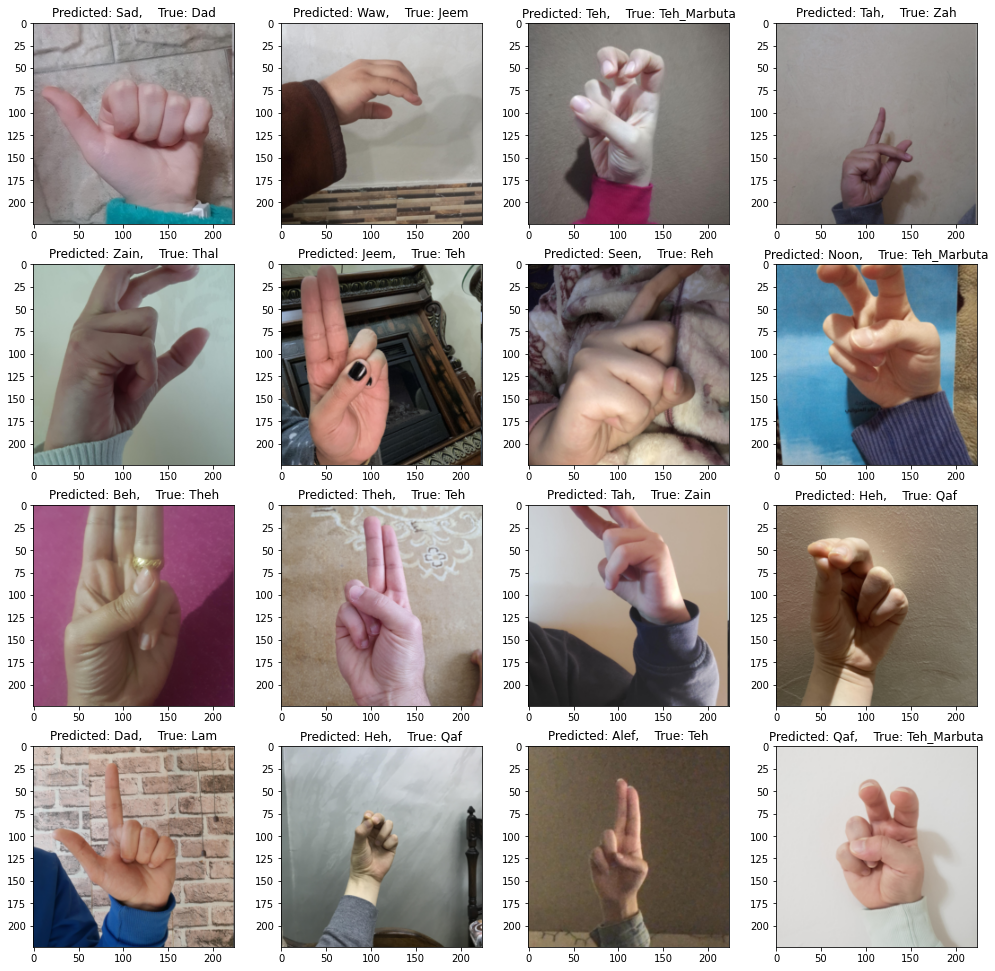

In [68]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[16:32]):
    plt.subplot(4,4,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


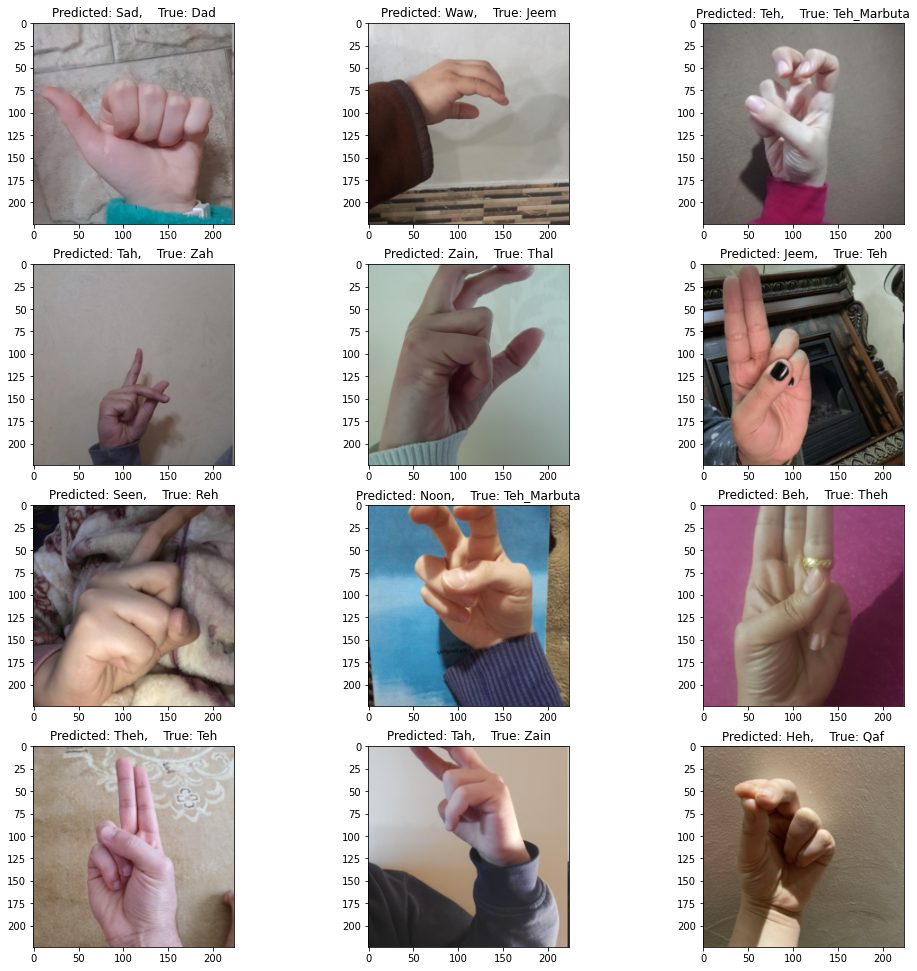

In [69]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[32:44]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


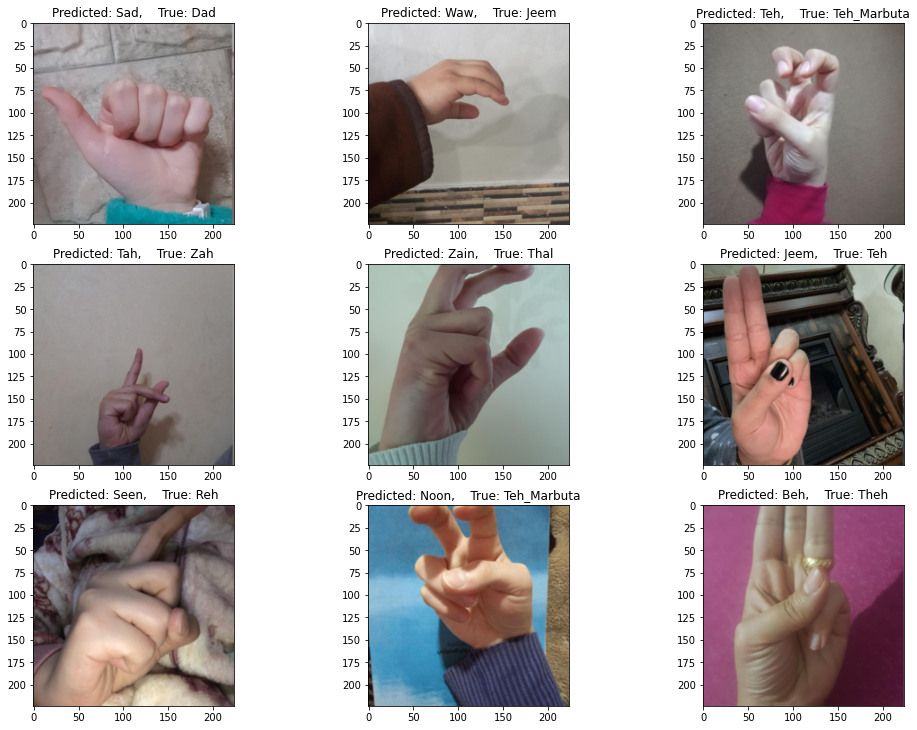

In [70]:
plt.figure(figsize=(17,17))

for i, img in enumerate(fault_images[45:54]):
    plt.subplot(4,3,i+1)
    # print("Predicted: ", idx2label[fault_images[i][1]], " ", "True: ", idx2label[fault_images[i][2]])
   
    plt.imshow(fault_images[i][0].permute(1, 2, 0).cpu().numpy(), cmap="gray", label="fdfsd")
    plt.title(f"Predicted: {idx2label[fault_images[i][1]]},    True: {idx2label[fault_images[i][2]]}")


## Plot the confusion matrix 

In [71]:
dic_class_idx = traindataset.dataset.class_to_idx
dic_class_idx

{'Ain': 0,
 'Al': 1,
 'Alef': 2,
 'Beh': 3,
 'Dad': 4,
 'Dal': 5,
 'Feh': 6,
 'Ghain': 7,
 'Hah': 8,
 'Heh': 9,
 'Jeem': 10,
 'Kaf': 11,
 'Khah': 12,
 'Laa': 13,
 'Lam': 14,
 'Meem': 15,
 'Noon': 16,
 'Qaf': 17,
 'Reh': 18,
 'Sad': 19,
 'Seen': 20,
 'Sheen': 21,
 'Tah': 22,
 'Teh': 23,
 'Teh_Marbuta': 24,
 'Thal': 25,
 'Theh': 26,
 'Waw': 27,
 'Yeh': 28,
 'Zah': 29,
 'Zain': 30}

In [72]:
idx_to_class_dic = {v: k for k, v in dic_class_idx.items()}

In [73]:
idx_to_class_dic

{0: 'Ain',
 1: 'Al',
 2: 'Alef',
 3: 'Beh',
 4: 'Dad',
 5: 'Dal',
 6: 'Feh',
 7: 'Ghain',
 8: 'Hah',
 9: 'Heh',
 10: 'Jeem',
 11: 'Kaf',
 12: 'Khah',
 13: 'Laa',
 14: 'Lam',
 15: 'Meem',
 16: 'Noon',
 17: 'Qaf',
 18: 'Reh',
 19: 'Sad',
 20: 'Seen',
 21: 'Sheen',
 22: 'Tah',
 23: 'Teh',
 24: 'Teh_Marbuta',
 25: 'Thal',
 26: 'Theh',
 27: 'Waw',
 28: 'Yeh',
 29: 'Zah',
 30: 'Zain'}

In [74]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [75]:
label_flattened  = flatten(labels_list)
logits_flattened = flatten(logits_list)

In [76]:
cmt = torch.zeros((31,31), dtype=int)
np_arr = cmt.detach().numpy()

In [77]:
for i,_ in enumerate(label_flattened):
   tl = label_flattened[i] 
   pl = logits_flattened[i]
   np_arr[tl,pl] = np_arr[tl,pl] + 1 

In [78]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    cbar = plt.colorbar(fraction=0.0457, pad=0.04)
    cbar.ax.tick_params(labelsize=40)

    
    tick_marks = np.arange(len(classes))

                        #  {'ain'   'al': 'aleff': 'bb': 'dal' 'dha' ,'dhad'  ,'fa', 'gaaf' 'ghain'  'ha'   'haa'  'jeem' 'kaaf' 'khaa'   'la'  'laam'  'meem'  'nun'   'ra'   saad'  'seen'  'sheen'  'ta'  'taa'   'thaa'  'thal'     'toot'      'waw'   'ya': 29          'yaa'   'zay'}
    plt.xticks(tick_marks, [r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah', r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta', r'Thal',r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'],fontsize=80 , rotation=90, fontweight='bold')
    plt.yticks(tick_marks,[r'Ain',r'Al',r'Alef',r'Beh',r'Dad',r'Dal',r'Feh',r'Ghain',r'Hah',r'Heh', r'Jeem',r'Kaf',r'Khah',r'Laa',r'Lam',r'Meem',r'Noon',r'Qaf',r'Reh',r'Sad',r'Seen',r'Sheen',r'Tah',r'Teh',r'Teh_Marbuta',r'Thal', r'Theh',r'Waw',r'Yeh',r'Zah',r'Zain'] ,fontsize=80, fontweight='bold')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=35, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel(r'\bf{True label}', fontsize=40, labelpad=10,fontweight='bold')
    plt.xlabel(r'\bf{Predicted label}', fontsize=40, labelpad=10,fontweight='bold')


Confusion matrix, without normalization
[[29  0  0  0  1  0  1  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  1  0  0  0]
 [ 0 34  0  0  0  0  0  0  0  0  0  0  0  0  3  1  1  0  0  0  0  1  0  0
   0  0  0  0  1  0  0]
 [ 0  0 40  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  3 32  0  0  1  1  0  1  0  1  0  1  0  1  0  0  0  0  0  0  0  4
   1  0  0  0  0  0  0]
 [ 0  0  0  0 33  1  0  0  0  0  0  0  0  0  1  0  0  0  0  4  0  1  0  0
   0  0  0  0  0  0  0]
 [ 0  0  1  0  1 20  1  0  0  0  2  0  0  0  0  0  0  0  5  0  0  0  1  1
   0  2  0  0  1  0  0]
 [ 0  0  0  0  0  1 22  0  0  1  0  0  1  0  0  3  1  3  2  3  0  0  0  0
   0  0  0  0  1  0  0]
 [ 5  0  2  0  0  2  0 23  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 2  0  0  0  0  1  0  0 23  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  1  0]
 [ 0  0  0  0  1  0  1  0  0 30  0  0  0  0  0  0  0  4  0  0  0  0  0  0
   2

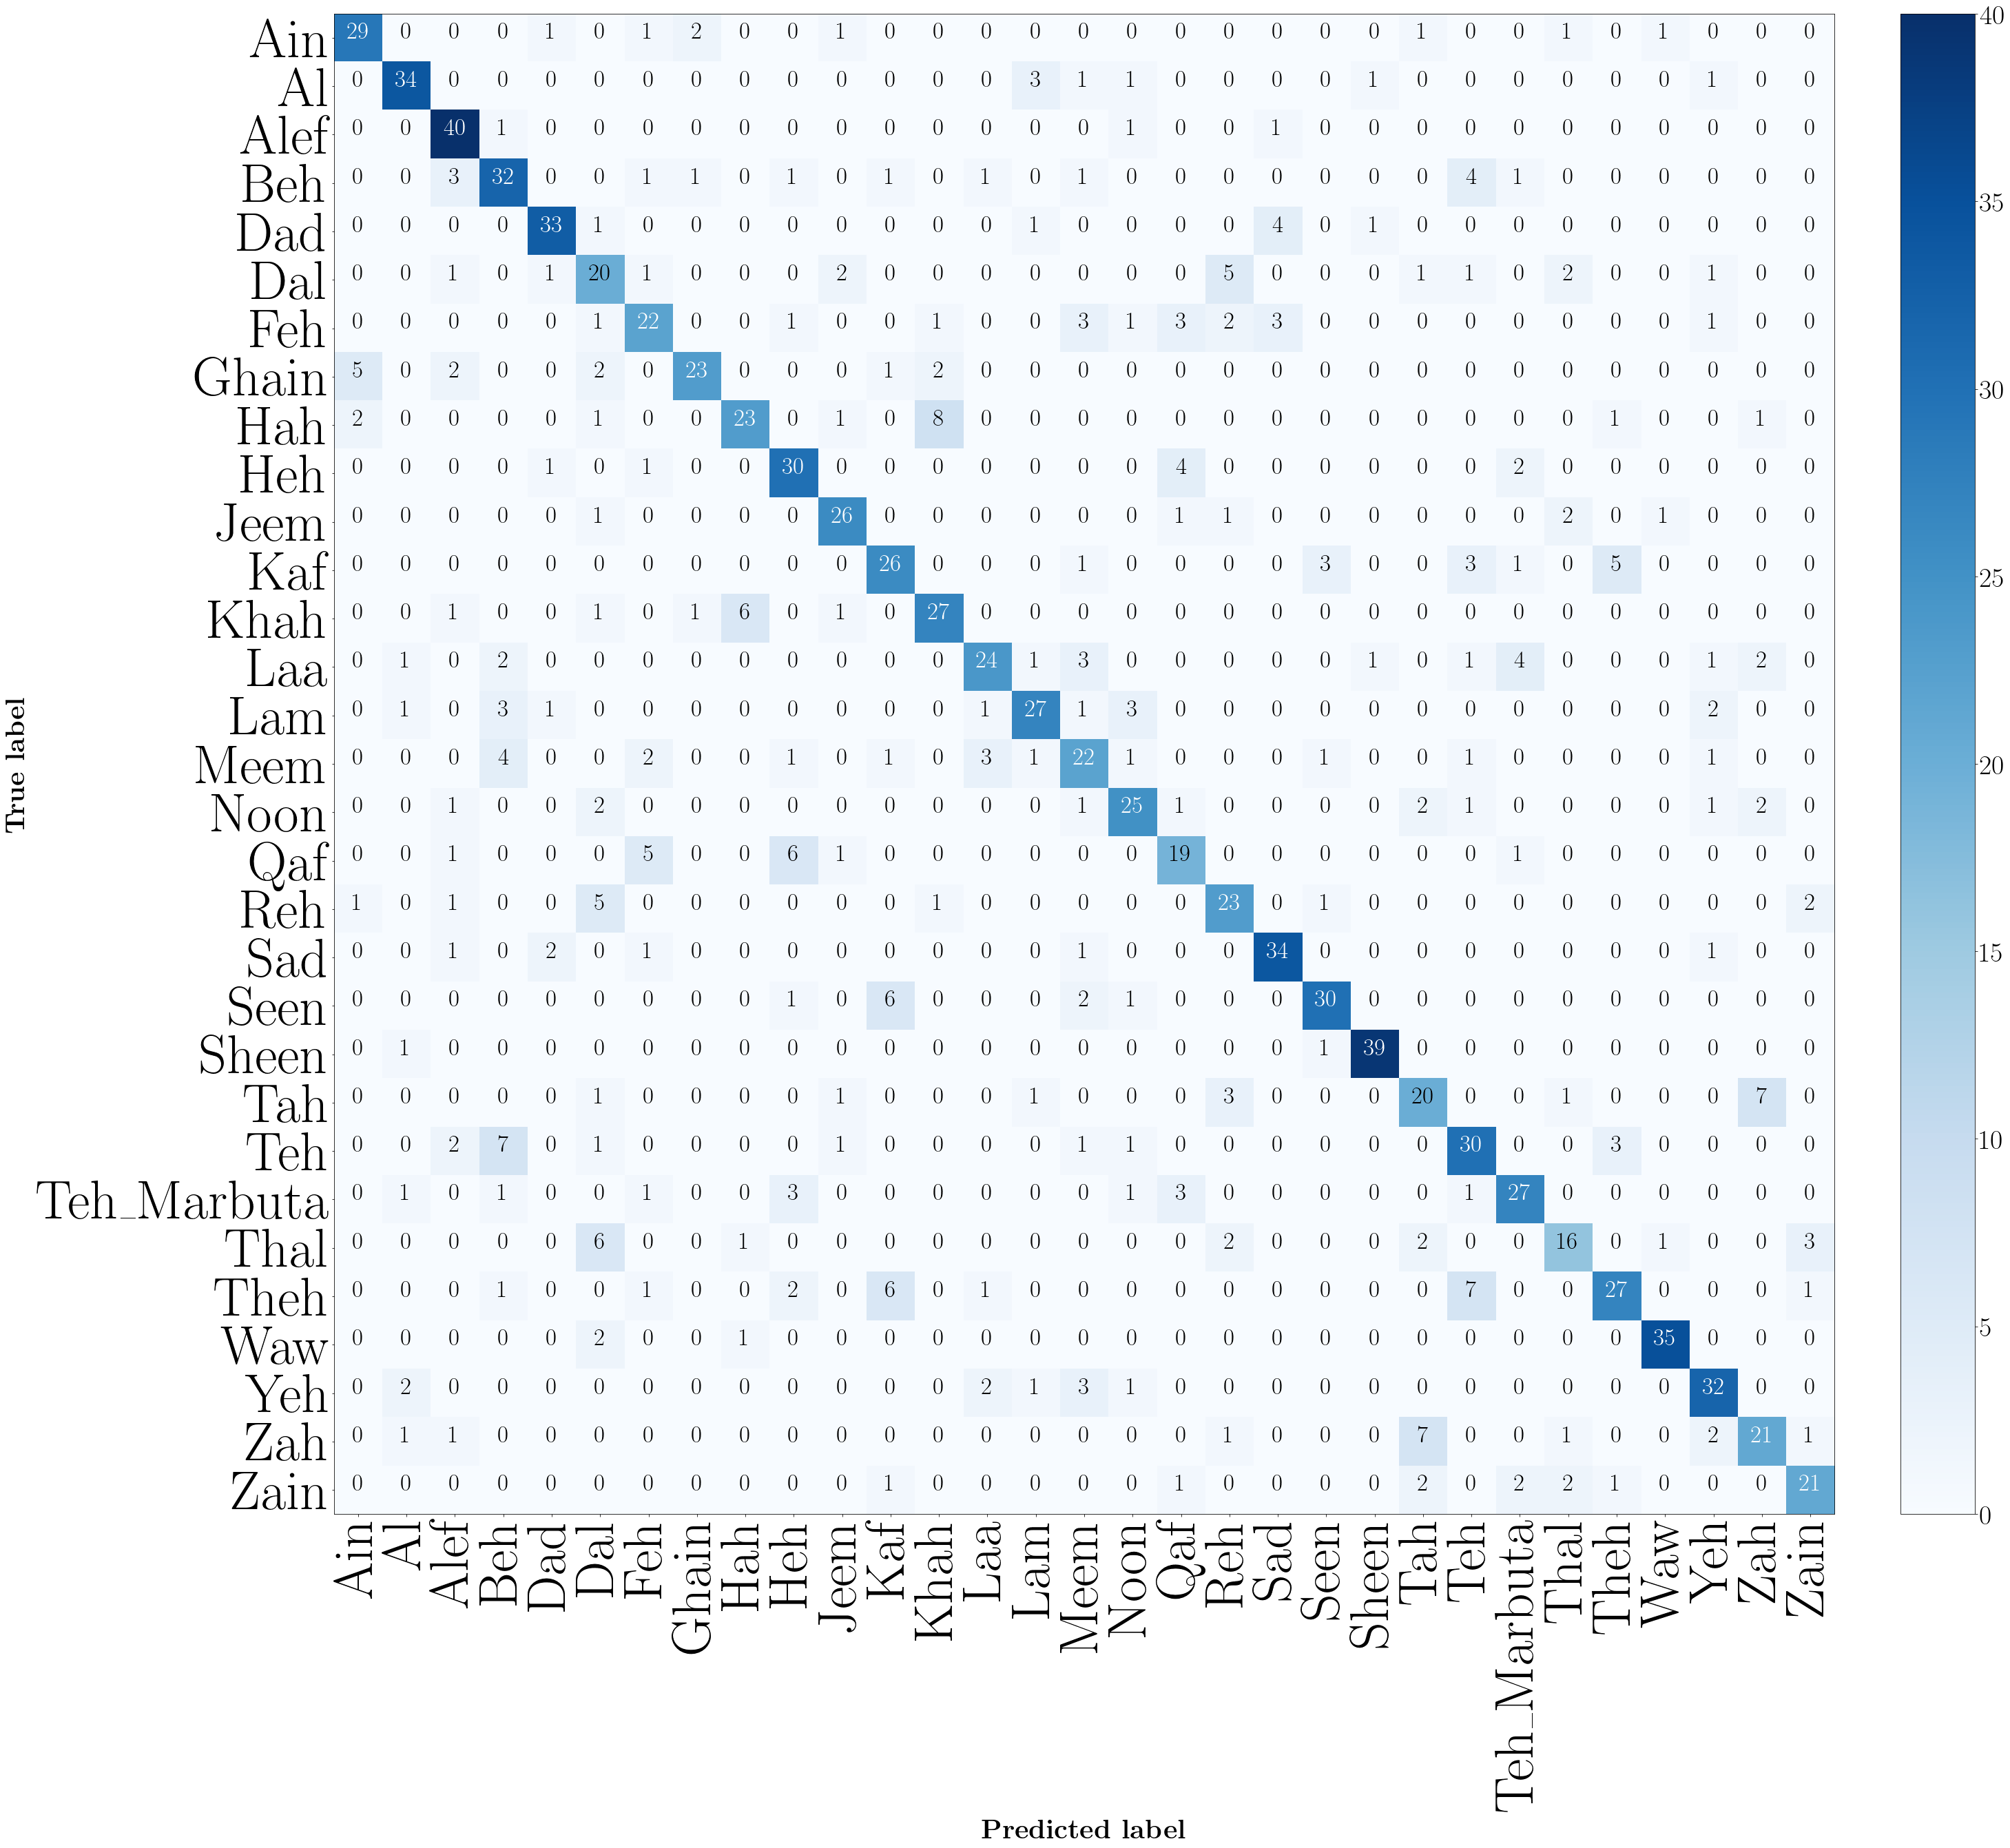

In [79]:
from sklearn.metrics import confusion_matrix
import matplotlib as mpl


plt.rcParams.update({ "text.usetex": True})


mpl.rcParams['font.family'] = 'cmu serif'
mpl.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(40,40))

plot_confusion_matrix(np_arr,dataset.classes)

print(dataset.classes)

plt.savefig(f"CM_{tensor_baord_variable}", format="pdf", dpi= 400, bbox_inches='tight')
